# Computational tools for data science: Comparing Recommendation Systems for MillionSongsDataset

In [5]:
# Imports
import math
import os
import pickle
import pprint
import re
import statistics
import time
from collections import defaultdict
from io import BytesIO
from zipfile import ZipFile

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
from datasketch import MinHash, MinHashLSHForest
from mlxtend.frequent_patterns import apriori
from mlxtend.preprocessing import TransactionEncoder
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from scipy.sparse import csr_matrix
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import paired_distances
from sklearn.neighbors import NearestNeighbors
from tqdm.notebook import tqdm
from wordcloud import STOPWORDS, ImageColorGenerator, WordCloud

import hdf5_getters as hdf5_getters

/Users/alejandranavarrocastillo/opt/anaconda3/lib/python3.9/site-packages/tables/__init__.py:24: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  from .utilsextension import (
/Users/alejandranavarrocastillo/opt/anaconda3/lib/python3.9/site-packages/tables/__init__.py:24: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  from .utilsextension import (
/Users/alejandranavarrocastillo/opt/anaconda3/lib/python3.9/site-packages/tables/req_versions.py:20: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  min_numpy_version = LooseVersion('1.9.3')
/Users/alejandranavarrocastillo/opt/anaconda3/lib/python3.9/site-packages/tables/req_versions.py:21: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  min_numexpr_version = LooseVersion('2.6.2')
/Users/alejandranavarrocastillo/opt/anaconda3/lib/python3.9/site-packages/tables/req_versions.py:22: Deprecati

## Read the data

Assuming that you have all the data in a folder called ```data```

In [6]:
# Read the songs dataset
with ZipFile('data/songs_cleaned.zip', 'r') as zipfile:
    data = zipfile.read('out.csv')

songs_cleaned = pd.read_csv(BytesIO(data))

In [7]:
# And pre-process the artist_terms feature

def ConvertStringtoList(string):
    s = string.replace('[','')
    s = s.replace(']','')
    s = s.replace('\'','')
    s = s.replace(' ','')
    li = list(s.split(","))
    return li

i = 0
for string in songs_cleaned['artist_terms']:
    list_ = ConvertStringtoList(string)
    songs_cleaned['artist_terms'][i] = list_
    i += 1

In [8]:
songs_cleaned.head()

,artist_id,song_id,artist_terms
0,ARMJAGH1187FB546F3,SOCIWDW12A8C13D406,"[blue-eyedsoul, poprock, blues-rock, beachmusi..."
1,ARXR32B1187FB57099,SOFSOCN12A8C143F5D,"[poppunk, skapunk, breakcore, alternativemetal..."
2,AR10USD1187B99F3F1,SOHKNRJ12A6701D1F8,"[post-hardcore, screamo, emo, hardcore, punkre..."
3,ARC43071187B990240,SOKEJEJ12A8C13E0D0,"[ccm, religiousmusic, losangeles, christianroc..."
4,ARL7K851187B99ACD2,SOMUYGI12AB0188633,"[bachata, merengue, reggaeton, latinpop, spani..."


In [9]:
# Read the user tastes' dataset

with ZipFile('users_cleaned.zip', 'r') as zipfile:
    data = zipfile.read('out.csv')

users_cleaned = pd.read_csv(BytesIO(data))
print(len(users_cleaned))
users_cleaned.head()

697064


,userID,songID,play_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOWEZSI12A81C21CE6,1
1,4bd88bfb25263a75bbdd467e74018f4ae570e5df,SODCXXY12AB0187452,2
2,b64cdd1a0bd907e5e00b39e345194768e330d652,SOLXDDC12A6701FBFD,1
3,b64cdd1a0bd907e5e00b39e345194768e330d652,SONQBUB12A6D4F8ED0,2
4,5a905f000fc1ff3df7ca807d57edb608863db05d,SOFKTPP12A8C1385CA,1


In [10]:
# How many different users there are
print("We have a total of", len(set(users_cleaned['userID'])), "users.")

# Let's take a subset of users to evaluate the performance of the various recommendation systems
nb_of_users = 5000

users_subset = users_cleaned[users_cleaned['userID'].isin(list(set(users_cleaned['userID']))[:nb_of_users])]
print("In the subset for the evaluation we have a total number of", len(set(users_subset['userID'])), "users.")

We have a total of 386670 users.
In the subset for the evaluation we have a total number of 5000 users.


In [11]:
users_subset.head()

,userID,songID,play_count
52,1a849df9dabb15845eb932d46d81e2fd77176786,SOLZOBD12AB0185720,2
53,1a849df9dabb15845eb932d46d81e2fd77176786,SOTRDVJ12A8C13975E,4
90,ed3664f9cd689031fe4d0ed6c66503bdc3ad7cb6,SOEHTZE12A6310F0F2,1
169,8fce200f3912e9608e3b1463cdb9c3529aab5c08,SOPWKOX12A8C139D43,1
170,8fce200f3912e9608e3b1463cdb9c3529aab5c08,SOZAPQT12A8C142821,1


# Content based recommendation

### Represent songs as vectors

We use the feature artist_terms and implement one-hot-encoding. With one-hot-encoding, we convert each categorical value into a new categorical column and assign a binary value 1 or 0 to each feature if the term was initially in the terms of a song.

In [8]:
df_songs = songs_cleaned

In [9]:
# First, extract the set of artist_terms

all_terms = []
for row in range(len(df_songs)):
    if df_songs['artist_terms'][row] == []:
        print('vacia')
    all_terms.append(df_songs['artist_terms'][row])

all_terms = np.concatenate(all_terms)
all_terms = list(set(all_terms)) # we have gotten a list of the set of all artist_terms

d = len(all_terms) # dimension of the vectors we are representing
print('Songs will be represented as binary vectors of dimension', d)

Songs will be represented as binary vectors of dimension 2294


In [10]:
# Now, we intend to create a binary vector (length = d) that represents a song, 
# with 1s if the song has this term and 0s if it hasn't.

def vectorize(song):

    index = int(df_songs.index[df_songs['song_id'] == song][0])
    vector = np.zeros(len(all_terms))

    for i in range(len(vector)):
        if all_terms[i] in df_songs['artist_terms'][index]:
            vector[i] = 1
            
    return vector

In [11]:
# Vectorize ALL the songs and save it into a dictionary

vector_representation = {}

for song in df_songs['song_id']:
    vector_representation[song] = vectorize(song)
    
#vector_representation # we end up with a dictionary of songs with their vector representation

### Get the user profiles

We will represent each user as a vector of dimension d. 
The representation is the weighted average of the songs that the user has already listened to.

In [12]:
# Compute all the results only for the subset of 5000 users
user_plays = users_subset

In [13]:
# Get the User profile: that will be a vector of dimension d computed as the weighted average of his played songs
# Get user profile for all users

def getUserProfile(user):

    song_counts = list(user_plays[user_plays['userID'] == user]['play_count'])
    song_list = list(user_plays[user_plays['userID'] == user]['songID'])


    # Check if the user songs are in the song dataset and get the indices of the songs
    indices = []
    for song in song_list:
        if song in list(df_songs['song_id']):
            indices.append(song_list.index(song))
        else:
            continue


    # Get the User profile (i.e. Compute the (weighted) average of the songs of a user)
    a = [song_counts[i] for i in indices]
    b = [vector_representation[song_list[i]] for i in indices]

    numerator = np.zeros(d)
    for i in range(len(a)):
        numerator = numerator + ( a[i] * np.asarray(b[i]) )

    user_profile = numerator / sum(a)
    return user_profile

In [14]:
# Get user profiles for every user in the users_plays dataset
# If users_plays = users_cleaned --> Very slow cell (it lasts 1 day). Set to True to run this cell. Or, read the already created dictionary in the file user_profiles.pkl
# Otherwise if users_plays = users_subset, (since it is a subset) OK.

create_user_profiles = True

if create_user_profiles:
    users = set(list(user_plays['userID']))
    user_profiles = {}
    for user in tqdm(users):
        user_profiles[user] = getUserProfile(user)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [15]:
# Save dictionary of user_profiles
# Set to True if you want to save the user_profiles dictionary as a separate file
if create_user_profiles:
    with open("user_profiles.pkl", "wb") as f:
        pickle.dump(user_profiles, f)

In [16]:
# Read user_profiles file and save it into a dictionary
if not create_user_profiles:
    with open("user_profiles.pkl", "rb") as a_file:
        user_profiles = pickle.load(a_file)
print("We have", len(user_profiles), "users in this dictionary.")

We have 5000 users in this dictionary.


### Get recommendation

We will recommend the songs of our dataset that are more similar to the user profile.

In [17]:
# Recommendations for all users

def getRecommendation(user):
    user_profile = user_profiles[user]
    
    scores_dict = {}
    for song in df_songs['song_id']:
        dist = np.linalg.norm(user_profile - vector_representation[song]) # euclidean distance
        scores_dict[song] = dist

    # R best recommendations
    R = 10
    recommended_songs = []
    for score in np.sort(list(scores_dict.values()))[0:R]:
        recommended_songs.append(list({i for i in scores_dict if scores_dict[i]==score}))

    recommended_songs = list(set(np.concatenate(recommended_songs)))

    return recommended_songs

In [18]:
# Create dictionary of user_recommendations
# Set to True if you want to create it again.
# If users_plays = users_cleaned --> Very slow cell (it takes forever)
# Otherwise if users_plays = users_subset, OK.
if True:
    user_recommendations = {}
    counter = 0
    for key in tqdm(user_profiles.keys()):
        if counter < 10000: # control parameter, if we have more than a certain nb of users, don't compute it all
            user_recommendations[key] = getRecommendation(key)
            counter += 1
        else:
            break

  0%|          | 0/5000 [00:00<?, ?it/s]

In [19]:
# Save dictionary of user_recommendations
# Set to True if you want to save the user_recommendations dictionary as a separate file
save_user_recommendations = True
if save_user_recommendations:
    with open("user_recommendations.pkl", "wb") as f:
        pickle.dump(user_recommendations, f)

In [20]:
# Read user_recommendations file and save it into a dictionary
if not save_user_recommendations:
    with open("user_recommendations.pkl", "rb") as a_file:
        user_recommendations = pickle.load(a_file)
    print("We have", len(user_recommendations), "users with their recommendations.")

### Evaluation of recommendation

We can use different methods:

#### Intra-list similarity

Intra-list similarity is the average cosine similarity of all items in a list of recommendations.
Intra-list similarity can be calculated for each user, and averaged over all users in the test set to get an estimate of intra-list similarity for the model.

In [21]:
# Cosine similarity
from numpy.linalg import norm
def cosine_similarity(song1, song2):
    a = vector_representation[song1]
    b = vector_representation[song2]
    dist = np.dot(a,b)/(norm(a)*norm(b))
    return dist

# Intra list similarity function
def intra_list_similarity(user):
    rec = user_recommendations[user]
    
    # All possible pairs in list
    pairs = [(a, b) for idx, a in enumerate(rec) for b in rec[idx + 1:]]
    
    # Compute the average distances between the pairs of the recommended songs
    distances = []
    for pair in pairs:
        distances.append(cosine_similarity(pair[0], pair[1]))
    
    return np.mean(distances)

In [22]:
# Get the intra-list similarity of the model
# Average of all intra list similarities

intra_list_similar = []
for user in user_recommendations.keys():
    intra_list_similar.append(intra_list_similarity(user))

print("The intra list similarity for Content based model is:" , np.mean(intra_list_similar))

The intra list similarity for Content based model is: 0.5209447271563011


#### Personalization (in progress)

https://towardsdatascience.com/evaluation-metrics-for-recommender-systems-df56c6611093

#### Evaluation based on similarity of recommended songs to the user profile

This method for evaluation consists of calculating the euclidean distance of the songs recommended to a user and the user profile. Then, we average these distances.

If we compute this measure for every user, we then get the score for our recommendations model.

In [23]:
# Compute the average of the distances of the recommended songs to the user profile 
# Distance can be calculated by euclidean or cosine similarity

def average_distance(user):
    rec = user_recommendations[user]
    user_profile = user_profiles[user]

    distances = []
    for song in rec:
        a = vector_representation[song]
        distances.append(np.linalg.norm(a-user_profile)) # euclidean distance
    return np.mean(distances)

In [24]:
# Get the average similarity of the model
# Average of all similarities

average_similar = []
for user in user_recommendations.keys():
    average_similar.append(average_distance(user))

print("The average similarity for Content based model is:" , np.mean(average_similar))

The average similarity for Content based model is: 3.120989606575042


# Random recommendation (baseline)

The random recommendation model assign a list of random songs to every user.

In [18]:
import random

user_recommendations = {}

for user in set(users_subset['userID']):
    user_recommendations[user] = random.sample(list(songs_cleaned['song_id']), k=10)

#### Intra-list similarity

In [35]:
# Get the intra-list similarity of the model
# Average of all intra list similarities

intra_list_similar = []
for user in user_recommendations.keys():
    intra_list_similar.append(intra_list_similarity(user))

print("The intra list similarity for baseline model is:" , np.mean(intra_list_similar))

The intra list similarity for baseline model is: 0.1417759426468122


#### Evaluation based on similarity of recommended songs to the user profile

In [38]:
# Get the average similarity of the model
# Average of all similarities

average_similar = []
for user in user_recommendations.keys():
    average_similar.append(average_distance(user))

print("The average similarity for baseline model is:" , np.mean(average_similar))

The average similarity for baseline model is: 6.369847014307481


# Clustering

Another method that we could apply to get recommendations based on content (in our case features of the songs) can be through clustering.

In this part, we cluster songs by similarity with K-means algorithm. Then, since we have computed the user profile for every user, we compute the distance of each user to the centroid of each cluster in order to obtain the cluster to which each user is "closer" to. Finally, the recommendation will be a random set of songs of obtained the cluster.

In [77]:
# Show the vector representation of each of the songs in a dataframe

songs_list = list(vector_representation.keys())
songs_representation_list = list(vector_representation.values())

index_dict = {}
for index in range(len(songs_list)):
    index_dict[index] = songs_list[index]
    

columns = []
for i in range(d):
    columns.append(str(i))
    
df_vector_representation = pd.DataFrame(songs_representation_list, columns = columns)
df_vector_representation = df_vector_representation.rename(index = index_dict)
df_vector_representation

,0,1,2,3,4,5,6,7,8,9,...,2284,2285,2286,2287,2288,2289,2290,2291,2292,2293
SOCIWDW12A8C13D406,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOFSOCN12A8C143F5D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
SOHKNRJ12A6701D1F8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOKEJEJ12A8C13E0D0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOMUYGI12AB0188633,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SOILDRV12A8C13EB77,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOBUUYV12A58A7DA27,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOUWMIW12AB0184748,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOLXXPY12A67ADABA0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [78]:
# K-means algorithm
from sklearn.cluster import KMeans

n_clusters = 3

kmeans = KMeans(n_clusters=n_clusters, random_state=42) 
kmeans.fit(df_vector_representation)
labels = kmeans.labels_

In [79]:
# How many songs are in each cluster
clusterCount = np.bincount(labels)
clusterCount

array([ 819, 1591,  785])

In [80]:
## Now we have every song in a cluster.
# We identify the centroid of each cluster (cluster_centers_) and compare each user_profile with these.
# We then recommend the songs of the cluster of with the user_profile is closer to the centroid.

cluster_centers = kmeans.cluster_centers_
cluster_centers

array([[-2.71050543e-19,  1.73472348e-18,  1.70940171e-02, ...,
         9.76800977e-03, -5.42101086e-19, -1.08420217e-18],
       [ 6.28535512e-04,  1.88560654e-03,  2.82840981e-02, ...,
         6.50521303e-18,  6.28535512e-04,  2.51414205e-03],
       [-2.71050543e-19,  1.73472348e-18,  4.71337580e-02, ...,
        -2.16840434e-18,  1.27388535e-03, -1.08420217e-18]])

In [85]:
# Compute the distances for each user to each centroid and recommend the songs of the correspondent cluster

user_recom_cluster = {}

for user, user_profile in user_profiles.items():

    distances = []
    for centroid in cluster_centers:
        distances.append(np.linalg.norm(user_profile - centroid))

    recommended_cluster = np.where(distances == min(distances))[0][0]
    print("For user", user, "we recommend the songs in cluster", recommended_cluster)
    
    # Get R recommendations from the cluster
    R = 10
    indices = np.where(labels == recommended_cluster)
    user_recom_cluster[user] = list(df_vector_representation.iloc[indices].sample(n=R).index)  

For user df6001316ed642cee6448396d1d12d4f1e685dad we recommend the songs labeled in the cluster 1
For user a2934b5c720cc101e81e82220bcc1786105c1a01 we recommend the songs labeled in the cluster 1
For user f1312711b28c85c6751f22e9db48c4031f63936f we recommend the songs labeled in the cluster 2
For user 371cd7bf43382cbfaae7148b5085443cfc16f0a7 we recommend the songs labeled in the cluster 0
For user 872e497431e26b7ffad6ab66752c0322d83f1304 we recommend the songs labeled in the cluster 1
For user b0c726003172912291aaa685f69a44577cf991ad we recommend the songs labeled in the cluster 0
For user 0723490a101de4f0bf8614af3609796690f74b21 we recommend the songs labeled in the cluster 0
For user 344117665c43b744945d356e1926a962a44fb814 we recommend the songs labeled in the cluster 0
For user 4d521c0ace1e87c1c5bd418831af034c38fa72d9 we recommend the songs labeled in the cluster 1
For user b6a09800278737ccffb5f027f2201a83bc044b67 we recommend the songs labeled in the cluster 2
For user 176c3e84403

For user 3a852626912296697c1be01d805f00d240fde3a5 we recommend the songs labeled in the cluster 1
For user a2fd8cb98ff56e48c07c7195cf51d88084964519 we recommend the songs labeled in the cluster 0
For user 242b2b8357b4656b50f86d5fcef4f76aa5ec9cf6 we recommend the songs labeled in the cluster 0
For user 7c768ac00b23c92015e25b3bdbbd3ac45be7835f we recommend the songs labeled in the cluster 0
For user 0f849719d85bb08e95029059bbcf22b9da5533c1 we recommend the songs labeled in the cluster 1
For user 3ad36ad08aedcd2a534ce5754363cc92663a6fe3 we recommend the songs labeled in the cluster 0
For user 6ffb1bd7056f1cf6e6c9208c1000bc01a9195499 we recommend the songs labeled in the cluster 0
For user d1182616d6bed5b878a33d1c861032f7f5388719 we recommend the songs labeled in the cluster 0
For user f539be85434d7c612b613f8380d236d44723f667 we recommend the songs labeled in the cluster 1
For user 8f4edc12c1e14d6e3ea48f536152d87bab73bbf4 we recommend the songs labeled in the cluster 1
For user 9d59afefcf5

For user f027e6b630b91cbc5d3053df7ef141d3cf754b36 we recommend the songs labeled in the cluster 0
For user 38a299c5793af9271ea6e4001be11abff30545e9 we recommend the songs labeled in the cluster 0
For user 7f42aec6d49972e85eb70777d1d15102d48e1207 we recommend the songs labeled in the cluster 1
For user 95dea19964ba2930b82ec06114d3c123df585cf3 we recommend the songs labeled in the cluster 0
For user 1ec2a5cb6bb212a3fe154c95ce025fd7c032ff9d we recommend the songs labeled in the cluster 0
For user 6b8a3d7f57ae3191ec8755c02e883ceeb90eb5bd we recommend the songs labeled in the cluster 2
For user 0e48c89476f9ee292d28098e03d107fe8e8726fa we recommend the songs labeled in the cluster 2
For user 98cac72768ce93be311e20510dc64db2365f64af we recommend the songs labeled in the cluster 1
For user eb22d8ab1c752ba4c0d03e3c2636cb55874bf3f4 we recommend the songs labeled in the cluster 0
For user 3339b358e6a3c56aedd305f11cca6050b861a48a we recommend the songs labeled in the cluster 1
For user 6bce137f837

For user a3a9329463c55f63876f84b0c47b4f90ca9db7bc we recommend the songs labeled in the cluster 2
For user b18e819f38283d674e65c310fdfbdcdfe698b9b1 we recommend the songs labeled in the cluster 1
For user 0daea651165ec9c49459f997228196c750fdb885 we recommend the songs labeled in the cluster 2
For user ef87152f6f9b3b026ffe2de90a44fb3963b5f934 we recommend the songs labeled in the cluster 1
For user 348f81ec390e849d1ff6f8a00e2fb4e89755bbaa we recommend the songs labeled in the cluster 1
For user 8ee8a20d10cc75728eee88c5e654ab3cc219f10e we recommend the songs labeled in the cluster 1
For user 7944201ca408cc97a3df9b9a5b90849516c0e3ac we recommend the songs labeled in the cluster 0
For user 6e80bead51d3fafdebbc415d12f98ecc3055a569 we recommend the songs labeled in the cluster 0
For user da7ff6ca5cbaabc73e28816338bb6e1c2658813c we recommend the songs labeled in the cluster 0
For user 5acf204a1211403ac2cb3ec7fe3e45fbceefc8cf we recommend the songs labeled in the cluster 0
For user 2ababf70a21

For user 925beaa1e212d59b81405566506a047a0e03fe1c we recommend the songs labeled in the cluster 1
For user a2ff703a371a75e6ef242dba30f7ff3aaf2eb86a we recommend the songs labeled in the cluster 0
For user 1647081c5a89eaaf405a876b0bc4bc53f95b0b1c we recommend the songs labeled in the cluster 1
For user d46215b603b0a79dabd0a70f6d70d764b39f2939 we recommend the songs labeled in the cluster 1
For user 250238d6b59465c2c98898fdd4dcbcc82d44fdec we recommend the songs labeled in the cluster 1
For user aa1136fe2699b9b69997a9fe007685d114911aa5 we recommend the songs labeled in the cluster 0
For user b16685598d4d02a2e954c62009b28adf1c14edeb we recommend the songs labeled in the cluster 1
For user d14cbb8fc46b961eeee354eaa4ec509d3c788554 we recommend the songs labeled in the cluster 0
For user 5e858c00ebd66366c11d3a94c8a7ce46db5735bb we recommend the songs labeled in the cluster 0
For user 1f1ddad476036049da406192d6ad43e764b8fd0f we recommend the songs labeled in the cluster 1
For user e8a92b562bc

For user 0fa55ae40580137fb3f0db4f3c17b27810a063fe we recommend the songs labeled in the cluster 1
For user 136d4f936361a80aec638c74faf3ffa5783503f3 we recommend the songs labeled in the cluster 0
For user a729b3d72372944c2f4cf52f18e3ba845e5a5a60 we recommend the songs labeled in the cluster 0
For user 3d03822e1527731096203ebbf0f4e9b56763d8c2 we recommend the songs labeled in the cluster 0
For user d91e104a2fd08b2523df25b62a717109480df256 we recommend the songs labeled in the cluster 0
For user 5a0628192bd508224549f1b86db3f22f5ca46811 we recommend the songs labeled in the cluster 1
For user b2aa0ec005dd3c4a367facc5112006ca2680222b we recommend the songs labeled in the cluster 1
For user 25c7712459364e18ef0114c4d2082e8d46fd4cd2 we recommend the songs labeled in the cluster 1
For user 63a6b5db0340c945eb8c8a9a01f6180e7be9c5b5 we recommend the songs labeled in the cluster 0
For user a63b2594b2d1c885af56c75dffd93926645f8054 we recommend the songs labeled in the cluster 1
For user 7a06dc05d72

For user fbdddc0d808c73464d92d41e22fe4a473a849316 we recommend the songs labeled in the cluster 1
For user 057e53c1cad74c54aa64a78649bab76e3f829102 we recommend the songs labeled in the cluster 1
For user 366e38b41844fb402372a9782a9ec223e6d92769 we recommend the songs labeled in the cluster 0
For user 89dbff99827c20a58a03b4e55b98ca10f723c5ee we recommend the songs labeled in the cluster 0
For user 2b95ce5731f0bfe97e894e21eccfec701e321a29 we recommend the songs labeled in the cluster 1
For user a296cb47d7757644153b2fc4eff2e53ac63933f7 we recommend the songs labeled in the cluster 0
For user 17c9aa57e496d1f53fcd96c7a7b5c727857cc41c we recommend the songs labeled in the cluster 0
For user 58fc85179a094a1971efaed027e2a2aaa9372011 we recommend the songs labeled in the cluster 1
For user 254d14eb2b7e2f9026416d191aa2fa65bf887179 we recommend the songs labeled in the cluster 0
For user 75c3f01aeece1bd07cb702e45d1d97f351ea7818 we recommend the songs labeled in the cluster 1
For user 6f218319f10

For user 267bc424cbc4115d4e458f7635f8a09070548aae we recommend the songs labeled in the cluster 1
For user 984b2fd0316f3a45b9472ebc9470ee533fe0d5a5 we recommend the songs labeled in the cluster 1
For user b5d9af2fe4a7aa26553aac2fda015778f72f1785 we recommend the songs labeled in the cluster 0
For user cd6af3c30ba3434b7724e1159e91f9e78fbe37d4 we recommend the songs labeled in the cluster 0
For user a3d4135a700a94be3285f82afe8a811cf006bbb1 we recommend the songs labeled in the cluster 2
For user d0caf538e13d14f4b73bff229e2505f319d781fd we recommend the songs labeled in the cluster 1
For user eb31d8bc32d295cf343e7f35af10838a80cd81b1 we recommend the songs labeled in the cluster 1
For user e9854b831d9d8eaf5ca7e1adbb87aa1929d40294 we recommend the songs labeled in the cluster 0
For user 7204ba295c33616e20231f2c5b4ec9a2948cea7a we recommend the songs labeled in the cluster 0
For user 67d0321562217f03be2ebd60668175672860b726 we recommend the songs labeled in the cluster 1
For user 3a4a930cc62

For user 72990d6b74425da26882900544f44d51087229a8 we recommend the songs labeled in the cluster 0
For user e6d78a75c45bf4899098a7dc24844a28a3494aec we recommend the songs labeled in the cluster 2
For user ffddd00c0de7f244bb2670d898c0d2fb671145d4 we recommend the songs labeled in the cluster 0
For user c1a8c8d8042e641d644dccc91c94724a82ca4a93 we recommend the songs labeled in the cluster 1
For user 255d7f5f284446364a769c49089b38f5952cca1e we recommend the songs labeled in the cluster 0
For user 1618871e6603ea2189acb18bc0481573d118588b we recommend the songs labeled in the cluster 1
For user 525ebb3c12a872e19a2364ef5176c24e7a7bdefd we recommend the songs labeled in the cluster 0
For user 2f0fb365154b7a622e963328ad4112a8c40ecaad we recommend the songs labeled in the cluster 0
For user 5256477ae72849c8f6a39b1610286b8e3d19ab8e we recommend the songs labeled in the cluster 0
For user 875f18356cdb18035e4e0bc23e2b1158b050ea90 we recommend the songs labeled in the cluster 2
For user 92997218914

For user 4e9868c87f2c423e29cc7f1dd57539f8ac4a28ef we recommend the songs labeled in the cluster 0
For user e56e47b1bd9db888fbf4ff26c13858647e068b20 we recommend the songs labeled in the cluster 1
For user 107f5d77c7fe9738297bb88ca21f70c789f3f567 we recommend the songs labeled in the cluster 0
For user 830911e4b932172f3acb14b519c0546f713bf032 we recommend the songs labeled in the cluster 1
For user f0c4f784e4b88c83e3191950ac6ab6fd52590329 we recommend the songs labeled in the cluster 1
For user 517ef887b143983db099feeede5f20bcd4d9cf68 we recommend the songs labeled in the cluster 2
For user f38c49b36487b910f8be4e5160b55ddde9da1aee we recommend the songs labeled in the cluster 0
For user cadb781e1c470589639353c1f4aede541ec68510 we recommend the songs labeled in the cluster 0
For user 99019df0f9e4d8916c8bdab2bd99a22cd3d54393 we recommend the songs labeled in the cluster 1
For user 3b79e0f87fb1baf1e1f338ba4f85bb67ab232d83 we recommend the songs labeled in the cluster 1
For user a836a8400bb

For user 75004c36442e16be038c33a93bf656a34977d62f we recommend the songs labeled in the cluster 0
For user 0c6553d4e13475023c16645f95023a73c4401da0 we recommend the songs labeled in the cluster 2
For user 40b5d20a1948c891ae69b4072889157aaa63a602 we recommend the songs labeled in the cluster 0
For user 7fa1079530b405df9a9c0c6592b3361e38065415 we recommend the songs labeled in the cluster 0
For user 3cee65e893af69580e5d4b39c8e87599d3a5d9ca we recommend the songs labeled in the cluster 2
For user cfa100c9de8d0ef311e9588ba2d7ef23ac096e46 we recommend the songs labeled in the cluster 2
For user 6da956ec41a7c998bcf46693b80c16361cf53638 we recommend the songs labeled in the cluster 0
For user 038224d008ecf75ca189678732bd19736cde6e32 we recommend the songs labeled in the cluster 0
For user db51f9313251a92d7fc567023c8d91874bd49ba8 we recommend the songs labeled in the cluster 1
For user b371de4aed7d22604e0cce0d6ee1d59a75151c8b we recommend the songs labeled in the cluster 0
For user 634c857b043

For user ece768f6014f3a19031dcfa113f3027cc32d7ded we recommend the songs labeled in the cluster 0
For user 0edd4e09a9e73ad043dfd711c14923348ef8e0cb we recommend the songs labeled in the cluster 2
For user f23d655e5d2350972482a242e4780461eb0f0e77 we recommend the songs labeled in the cluster 0
For user 7dd7a8e8f72114df133fa13431b4e4c23e83a9ea we recommend the songs labeled in the cluster 0
For user 92fb206418877a85e7ea73c043bbcf90db2b12c2 we recommend the songs labeled in the cluster 0
For user 2e0da26fbe8346588f2a63bebde610e15897b58b we recommend the songs labeled in the cluster 1
For user 0f8130675e75fd601839487b584127c4badc8f79 we recommend the songs labeled in the cluster 1
For user 793de27a47543ce5d2c3925303a9f543cb05431f we recommend the songs labeled in the cluster 0
For user f996220f17a1240a49cd825629b95ca587f7da8e we recommend the songs labeled in the cluster 1
For user b5cfe93c6bd88892276ad21a21a6d63c04edfa44 we recommend the songs labeled in the cluster 1
For user 829c358943f

For user eca1020143fcb09d0d82cd38b8f9cff1c68869d0 we recommend the songs labeled in the cluster 1
For user b38424e6254501e54f5e3f52f8d4783dd278d227 we recommend the songs labeled in the cluster 1
For user 77721de265c7841e93d9918a1899e3b57e279043 we recommend the songs labeled in the cluster 0
For user 7613a2ba32dc581b7ac17bd591548ef89aa906f4 we recommend the songs labeled in the cluster 2
For user cb546bda0675c1cd4118f940d6a8d68f1c66c011 we recommend the songs labeled in the cluster 2
For user 05c07df00d66cba94f92cc2447745933febec694 we recommend the songs labeled in the cluster 1
For user 6e5fb193ea8f41b22366d365f70fa9effe1053dc we recommend the songs labeled in the cluster 1
For user 20d07463d3118751ca08f65fa05ad7b2e0e8f1ca we recommend the songs labeled in the cluster 2
For user 14e004d2eeda31c5a9fcd87475b3567e485e18db we recommend the songs labeled in the cluster 0
For user e96360458efc9a93ed4dfc344769040577d0a9d6 we recommend the songs labeled in the cluster 1
For user 27a26797dce

For user bae1788843310fea9b2d4087fefb9a82fc68e917 we recommend the songs labeled in the cluster 0
For user 3b2904c71593d3b23552c5f6beebb971a3081f0d we recommend the songs labeled in the cluster 1
For user b0268c505bbb0e2ca7f7bb65f9d51edffeeaeb2c we recommend the songs labeled in the cluster 1
For user 3bbe20a8a19d661a9ac7a7ab9d2cd94556767f69 we recommend the songs labeled in the cluster 1
For user e4991790f367af29ad51a4e61ee28196357d8d64 we recommend the songs labeled in the cluster 1
For user a5eeb0eb94f9ca7ea7d5c7029077de30ab2c82a3 we recommend the songs labeled in the cluster 2
For user ec188c7e2ee83d7e68cabeba9286813966ca882d we recommend the songs labeled in the cluster 0
For user df87075d32f6c671efa182833bfcf890e54feb16 we recommend the songs labeled in the cluster 0
For user b3c58f1259c0712e5c99588c6b965486df71962b we recommend the songs labeled in the cluster 2
For user a3ecc9e50cf9cbb6caa7423e652a197d6e3232d1 we recommend the songs labeled in the cluster 1
For user 25e9eb25b09

For user cb872a318131a31e746f5f5a088bc7ab933c782a we recommend the songs labeled in the cluster 1
For user 4f548d4af1b554ce4185d2c032d3f298b6e916cb we recommend the songs labeled in the cluster 2
For user 969475b0b3ef95ed17db293f0c5bf636951aff24 we recommend the songs labeled in the cluster 0
For user 8fd88b4034c535381709ae3a10051a1e712e2b1c we recommend the songs labeled in the cluster 0
For user 1ceb52864e426f088b5619feadec7ff113065fc6 we recommend the songs labeled in the cluster 0
For user b66e968d97710e97db0f629634afab4c18e25845 we recommend the songs labeled in the cluster 1
For user c1ee959a4deedbb95b6928e6ac45f8152a2eb2ec we recommend the songs labeled in the cluster 0
For user 2d477556e99a248183037cca8768599604fabf4f we recommend the songs labeled in the cluster 0
For user 6dde0137ce3bb33f8ea21fdd06603705e82f6511 we recommend the songs labeled in the cluster 0
For user 573283d4cf089f41b27d3e09dd61a38c58b9461d we recommend the songs labeled in the cluster 1
For user d364e3b9ad4

For user 549aa8ae2a6ffbb575e1d047fc0038c8b405d78a we recommend the songs labeled in the cluster 1
For user 402d29c404cd5dffd20e0870b8e0b5ce178ce35a we recommend the songs labeled in the cluster 0
For user 12ed56bf3386e7bf046aa40f5a6faec72db26e5a we recommend the songs labeled in the cluster 0
For user 83a88b5f89db87dc945a3a44e2a520a9ffe6af38 we recommend the songs labeled in the cluster 0
For user 509ff25036572fcb23d45d80501c6effaa1e4424 we recommend the songs labeled in the cluster 0
For user 5a12ec02c5c26d6868177030d465878cd43f97b5 we recommend the songs labeled in the cluster 1
For user ec6fb743e42326e9007819c1ed40386d4f76e00d we recommend the songs labeled in the cluster 0
For user 1c07d91b8b6a7577ada468baad94a9462f93c2b9 we recommend the songs labeled in the cluster 2
For user dfc66859880e5a8e8ef5e345df3b1362a408c521 we recommend the songs labeled in the cluster 1
For user 0418d2cfab2d0ca4bb7be2d924a18cd23d38b5af we recommend the songs labeled in the cluster 2
For user 44e8557ed6f

For user c98a6ce0cbbc8a9ddc6b36ede247f0a9e74348df we recommend the songs labeled in the cluster 1
For user 662a9b1d1fa71b1eadf23125bd950a01a65b2b9f we recommend the songs labeled in the cluster 0
For user 56d04a74de62b16dbe0da517deba42caebf79d22 we recommend the songs labeled in the cluster 0
For user d070abc92712f25c8569c2ce9efa5efb5e9d2344 we recommend the songs labeled in the cluster 0
For user a4704d19932a20752bba242a888305299c7d2881 we recommend the songs labeled in the cluster 1
For user db99fa6bafe1b03cb5c1c263792bfe7c2653a82a we recommend the songs labeled in the cluster 2
For user a66eabfd3cdb84e3aff7bc331e44ebb0707ea2bc we recommend the songs labeled in the cluster 1
For user 973a5aa2bd52c347715ae70395b39c63a76df5e9 we recommend the songs labeled in the cluster 1
For user 524e1c357a85fbefa9f3e07c94886f4843e75d26 we recommend the songs labeled in the cluster 1
For user 4f6a36cd1fd5f0699d47737d1a9eaf76c6110bd6 we recommend the songs labeled in the cluster 0
For user 54de6a5e0c8

For user 050684ea2856f8a5277de788be9d80d2272074a3 we recommend the songs labeled in the cluster 1
For user 76eee4412fa2fed549c3a6c5f6612dae97de1a27 we recommend the songs labeled in the cluster 0
For user 82dc56a3fd10f09844f4b12c892b0278a0e971df we recommend the songs labeled in the cluster 0
For user 0cf11144c5075f4d6f9e4c82132746be901c75d5 we recommend the songs labeled in the cluster 1
For user 77af4a214a96fab064e27ce8c9760dfafd40f063 we recommend the songs labeled in the cluster 0
For user f10ecbe21ef0fbfb2ce19ca83d0fabb07adb3d11 we recommend the songs labeled in the cluster 1
For user 5e68b943e41f1a8d962d528b145e1120ccbcd59a we recommend the songs labeled in the cluster 1
For user f5eff4f95d46e927cd7d1b7ee4f0b6a0f7919af2 we recommend the songs labeled in the cluster 0
For user 76361d64de9403a47dc22d98067943eedef39c33 we recommend the songs labeled in the cluster 0
For user 9795f727714cdd5b09a15a9d2dc922c83e3f6b78 we recommend the songs labeled in the cluster 0
For user c7c5f6a0230

For user 7ec01f76b44529d2fdb8493827cf64263409a775 we recommend the songs labeled in the cluster 0
For user 59568292ae96c62737e90671757ddcf8dccd0f38 we recommend the songs labeled in the cluster 0
For user b102f5cb50f4d4770f7dfb902f6ca8548ffb0f85 we recommend the songs labeled in the cluster 0
For user 864d778a6e77817ef59cd45ccf75da559119ddd1 we recommend the songs labeled in the cluster 2
For user c1843b84073b0a9e8c27c6c9186878c91184e9ef we recommend the songs labeled in the cluster 0
For user 41ddcff035e0421d5c0e40d604772fcba517cbb5 we recommend the songs labeled in the cluster 0
For user 5a46180b1626024792353e57797946f2024557cc we recommend the songs labeled in the cluster 2
For user e9c83d15e1cb7ba710b86a4715c88f10492cd28a we recommend the songs labeled in the cluster 2
For user a36578928c32ebfb8daff3ca4588692751912e46 we recommend the songs labeled in the cluster 2
For user 6582d033927bf8fb4259be3c311b6ec0c860938e we recommend the songs labeled in the cluster 0
For user 194b2d90861

For user 41a2cf62d2a2a9d4ef2a9c53b56f0975ea6e8fd6 we recommend the songs labeled in the cluster 0
For user 2ad6ca2211a3b1746f5c44d5da83a83d24373b94 we recommend the songs labeled in the cluster 0
For user 92b297808bfb8d24645aec03403cb40a2faf921c we recommend the songs labeled in the cluster 1
For user 7a4c6b3933ca7f416cab8959ce6bbb814f0b4d0a we recommend the songs labeled in the cluster 1
For user e54828bb811d117f6903a90aa9f14462bf9cc7e7 we recommend the songs labeled in the cluster 1
For user 9219893d962ea9749c3776f0adb02f46729fa91d we recommend the songs labeled in the cluster 0
For user 22a47f97249f2af151f4df47b01edea6dc8ba2c2 we recommend the songs labeled in the cluster 0
For user 3d7ef4e80fba7483bb3fc8c3f15076c07f32cbda we recommend the songs labeled in the cluster 1
For user d83c7dc3204fb78d0c01a8d75733b4b7ef373c91 we recommend the songs labeled in the cluster 0
For user c5a97a578815ca24b6437a1860941fea2538216a we recommend the songs labeled in the cluster 2
For user 49710a21459

For user c433aa02843680d8b70c5f2e4605c7f864d7b337 we recommend the songs labeled in the cluster 1
For user 3f97f0e0ede20b939e77dc1a16a05c453d6e3512 we recommend the songs labeled in the cluster 0
For user 41bc8769e920afb52a216fceb849ea30e723ed50 we recommend the songs labeled in the cluster 2
For user 74d0c24a0bb5bde014ffbf57fc5c51b9b5b799a0 we recommend the songs labeled in the cluster 1
For user 607693da1d5bc069e398645d213ca60361ecf458 we recommend the songs labeled in the cluster 2
For user 775b0cfa7c811be0afdd76fd39a4773dd3a22a77 we recommend the songs labeled in the cluster 0
For user b78331afc01f6c04c89f43112005553b178585a2 we recommend the songs labeled in the cluster 1
For user 8b452f7bb663d2e3f133fe83a05b4467a7010cee we recommend the songs labeled in the cluster 0
For user bfae0670cd7fd9b5c2566d73578315ce03a83310 we recommend the songs labeled in the cluster 2
For user 65507ccb3dca0d5085e6cfcaacf6bf602bb546db we recommend the songs labeled in the cluster 2
For user 171fa8289b4

For user f8c2bfb3547487c7ae3742843ecde6fcdc8a4b4d we recommend the songs labeled in the cluster 0
For user 454f01bef61f35b10058726acc2a14f6d32d94fb we recommend the songs labeled in the cluster 0
For user 40eb64685755bac248a407b9de168d2fd42aa437 we recommend the songs labeled in the cluster 1
For user 9b1a72b2b2d0622a61a9b8ad8a21077ef5d2f844 we recommend the songs labeled in the cluster 1
For user 8830e3eaafb134d6650e1616fccd352be7c0f08d we recommend the songs labeled in the cluster 1
For user da0f0b8660d6e8595fd5a0d01f5a70490bcacdd5 we recommend the songs labeled in the cluster 1
For user c43daefdc7b465db09526adbf5bff18270f35528 we recommend the songs labeled in the cluster 1
For user b7750e29164f8a1dad73cb3e3a5c0b577de6d460 we recommend the songs labeled in the cluster 1
For user 8ed843ac4f3c212b78a812b9aea9d5a95add30ea we recommend the songs labeled in the cluster 2
For user db338cad96933ac77961e32a014f11f238796524 we recommend the songs labeled in the cluster 0
For user 5509d7d958b

For user a816ee2991d0298d3f3ab402ea7125c754ae8b9d we recommend the songs labeled in the cluster 2
For user 9826b9bba35ddba6fda05291760f67965d171d9d we recommend the songs labeled in the cluster 1
For user 5a615b694f2c76389395d917b42996ad8d99fd77 we recommend the songs labeled in the cluster 1
For user 8bbc99165dbdd61275a617a601ab28cb5cdc59ed we recommend the songs labeled in the cluster 0
For user fa040e04fbf8e4b50e88b9ac37436dc4723acb01 we recommend the songs labeled in the cluster 1
For user 5b3265b318ecdc49e76f95810fac66bde070fc25 we recommend the songs labeled in the cluster 0
For user 546c2f080b19a4bd913d7f742d560bf0902c5eb9 we recommend the songs labeled in the cluster 1
For user 90610e0f0a8ca72e83cbeb8bb309f596de0ec659 we recommend the songs labeled in the cluster 1
For user fc1a0f71ef6cc8b12a13c4b25b24a9d33da7ac09 we recommend the songs labeled in the cluster 1
For user ffc2e8cddcbd244a2e581adc0c6bd50de4b96ce1 we recommend the songs labeled in the cluster 0
For user fee86c18b8b

For user ca9cf4ad546f2ce7684b7837118a56e8b294e681 we recommend the songs labeled in the cluster 0
For user 948c268af79928adec97d6c638a8e314609d7cc8 we recommend the songs labeled in the cluster 1
For user 1fd61468a8330fe95ff6f057a385f6005f777c13 we recommend the songs labeled in the cluster 0
For user 900e36c94ca31ebc739bd4bf976e9fd0519b1729 we recommend the songs labeled in the cluster 1
For user d9673be796b30da4a01ec906e056184dd690e581 we recommend the songs labeled in the cluster 0
For user 24dfc06b454ac8d1cbd2c354a7b6b45d081b6403 we recommend the songs labeled in the cluster 1
For user f7690dc9b511273a50329f55bd963f6c69c5ab64 we recommend the songs labeled in the cluster 0
For user cdf6f1a180a415636623256f2711e105c79bdce4 we recommend the songs labeled in the cluster 0
For user 306674b9281dd78b9031c420a88b2dc95fc66699 we recommend the songs labeled in the cluster 0
For user 7227db7d5ff201eed6b8178d6423b3879920b50d we recommend the songs labeled in the cluster 2
For user f8ec3e3db77

For user 403c9ecf07a0221a70c43136bc1dcadbbb1275fd we recommend the songs labeled in the cluster 1
For user 28ff6ebee3b858781e9c884ba4fd170293cd9cd2 we recommend the songs labeled in the cluster 0
For user e0a6907d89a6db2ee5b4a6641ee986e6e5587c21 we recommend the songs labeled in the cluster 0
For user edd583368975c7a28c15541feef68162a5b00969 we recommend the songs labeled in the cluster 2
For user 38d5d1abda797a3e7bf0e0ef00afa02e3f27fd95 we recommend the songs labeled in the cluster 1
For user 9c079a441371e37b91add07a501850a69ee5342e we recommend the songs labeled in the cluster 2
For user 1b76e350c065175a02ba299feb31031a94ad656c we recommend the songs labeled in the cluster 2
For user 3840dd1913122b9693c6f1954ef4c44806ca59a6 we recommend the songs labeled in the cluster 0
For user 2e411927e595a90d58fa299696979aa8a79cf15e we recommend the songs labeled in the cluster 0
For user 9e9bf9dd80c3adef8fe7f5d95da53ea279409393 we recommend the songs labeled in the cluster 1
For user 8b381c5ef8c

For user bd7cfe6a966f425f66bb5e89e1ae94e2582bc3a9 we recommend the songs labeled in the cluster 1
For user a1902aaaa7908c8d93bbd343e0fcfe724799f0f6 we recommend the songs labeled in the cluster 0
For user 3e491f950bf2a73d5fe45b71e62aa6fb6c925bd5 we recommend the songs labeled in the cluster 1
For user e54420a2901017d4c3ccf4cef77d48c2b40cf033 we recommend the songs labeled in the cluster 0
For user fc40677444a3781ea61d816f3852402387cb4853 we recommend the songs labeled in the cluster 0
For user a135f1dce458ba1cd76b4d6a9f8d736a48260a2b we recommend the songs labeled in the cluster 2
For user 331f291ba6de96a8bd6b23135e31a3eb3582d01b we recommend the songs labeled in the cluster 0
For user 5d6422228b4afaa09457ecfbcdd7a42f29cccc07 we recommend the songs labeled in the cluster 0
For user d4f51dec6bfb4d210ff8e53b828135c0885a3882 we recommend the songs labeled in the cluster 1
For user 6ca7ad210b61631b846f346d28c2de1fc9268c99 we recommend the songs labeled in the cluster 0
For user 97cbb3043d0

For user 24f5ccd02c284edacca2fd43c7dd443d929708d2 we recommend the songs labeled in the cluster 1
For user 094cd16b637bf835f8d286442ad2923f10f620f0 we recommend the songs labeled in the cluster 0
For user 0899b69716d5b58fdeeb35153be10a05940f296a we recommend the songs labeled in the cluster 1
For user 3ea4f8bf8942b41619106756157cd4d5f617e7f1 we recommend the songs labeled in the cluster 1
For user 91a0c8c851489152169146ef4d5b6e62f2716f4a we recommend the songs labeled in the cluster 0
For user 5ab9d177cc703bad47400c24ac3e54372eada9fb we recommend the songs labeled in the cluster 0
For user bf792b80c2d1e8a57c943c319413de948e2cdf49 we recommend the songs labeled in the cluster 0
For user 6e0560b7975add04ba90c0a129a7e4f514218dc8 we recommend the songs labeled in the cluster 0
For user e907fa0ad5f9758fc63a48dc20ee0c45d081edd6 we recommend the songs labeled in the cluster 2
For user fccfb41333fc0bff324a1e67e3663e2319a62d6a we recommend the songs labeled in the cluster 0
For user a8332760848

For user 43752dcabb9adf3fc5c7c98c61df649126a0d253 we recommend the songs labeled in the cluster 2
For user 0c282bfe256acb2f85ba5d36b67daa420c17f1d7 we recommend the songs labeled in the cluster 1
For user 1aa394a989c82ca2084c028efe0e56776166153a we recommend the songs labeled in the cluster 1
For user 55be00dc88a3726e3435ca0e1146fb59c5bd5fe3 we recommend the songs labeled in the cluster 0
For user 5765785fa8eadcbb0606f547e7254df526987871 we recommend the songs labeled in the cluster 0
For user 66801ace83824cf288627bc6aceb425a07dc408f we recommend the songs labeled in the cluster 1
For user 66918477d2ef4bc209e07e186c3c1a976cc8c0af we recommend the songs labeled in the cluster 2
For user b2fe0c03c44017297c92d95edd166acd2fcf0c2b we recommend the songs labeled in the cluster 0
For user ff34d3f673368afe188ae6e420e13f69d9ce6c21 we recommend the songs labeled in the cluster 1
For user 1a1454fed2ce0c8d46867dcedc252009435ead5c we recommend the songs labeled in the cluster 1
For user cb5555fe990

For user b296cd7774f5bcc8b4b15a4f4d8fbed248e1427a we recommend the songs labeled in the cluster 2
For user 379996a833129ca80e04ec2b7b760cf35020051e we recommend the songs labeled in the cluster 0
For user 2512a3b507a0d6f410b1f7833ad2b989e7234962 we recommend the songs labeled in the cluster 1
For user f575d1c8bd1a1f3123d94bf24ae56c7a4a9ed63a we recommend the songs labeled in the cluster 1
For user 0fa0946a5eab3688933b8b3f1e52f5086e217abd we recommend the songs labeled in the cluster 1
For user 86fd0c7991533c20fbfcbaf5dfe55cd441d8bb8a we recommend the songs labeled in the cluster 0
For user 994bd186e08bc4054c8b7596f1a2ce1450b85ba2 we recommend the songs labeled in the cluster 0
For user 080de7930dd07315fc6ee1671a041028fe3448da we recommend the songs labeled in the cluster 1
For user 058131bfec15c1d66159dc970d6806e0f889baa7 we recommend the songs labeled in the cluster 0
For user 7a2683a0bf4fc1075ab3ca3268da34e7e0f6ffbc we recommend the songs labeled in the cluster 2
For user e43f872dd5a

For user d9e908e7a8b8360aa9bb61950b9da93f2ac1dec2 we recommend the songs labeled in the cluster 0
For user 07821d74a3064785423282cffb33f860d82487c6 we recommend the songs labeled in the cluster 0
For user 13584145c9a7da3b52ad68474fa1eb2dba2c4df7 we recommend the songs labeled in the cluster 0
For user 6f09546e5658ba569f7ac8f9007bc31ac492f7b8 we recommend the songs labeled in the cluster 1
For user db4f56ff51b81d63da3a5de02009b196276e08b4 we recommend the songs labeled in the cluster 1
For user ee5a4019c55ed8a291e79f393ebfc4bf00ea7652 we recommend the songs labeled in the cluster 0
For user 202928386dda4dd5b09c8cf4196f3e730fafbe6b we recommend the songs labeled in the cluster 2
For user 958c4bfab75977e2fadb075019f6026cd42149a2 we recommend the songs labeled in the cluster 0
For user 15de5fdebc3830ca0a8a01b8fc8bac3d60d8e9f1 we recommend the songs labeled in the cluster 1
For user 69563432aa55700447a80a960d0e01d18f3881c8 we recommend the songs labeled in the cluster 0
For user b57e7bd1c1c

For user c80a8eea6137895255baf00d91acbbd9757093fd we recommend the songs labeled in the cluster 0
For user 3b56eb8473286cfb89202a69409123f69f018a43 we recommend the songs labeled in the cluster 2
For user f19a7eb88d8c3d5a9d585e75e357325ec6d7a4be we recommend the songs labeled in the cluster 1
For user 6f55fabcbf2d32a879ee3fca1fe2a23490cfe072 we recommend the songs labeled in the cluster 0
For user 93b1e36c8623d58d07bdaa1476a1ab449ecd7d3d we recommend the songs labeled in the cluster 0
For user 798bb222656d225b5644481080468fdf8b0cfecb we recommend the songs labeled in the cluster 1
For user 1066a16cf5a96e019a2e98c2a9988d08199e3663 we recommend the songs labeled in the cluster 0
For user 1f91b2e56f17bb64fc1bd8f612eb4d4188d175b0 we recommend the songs labeled in the cluster 0
For user 50a9854c83d4d364ee6595a8587ad35a9869f889 we recommend the songs labeled in the cluster 1
For user 423c1b708fb21e6091fb5428885bbe3eef77397a we recommend the songs labeled in the cluster 1
For user 6ddb3e4a005

For user d6ec7fe9ecb57728d95fa9e361d13e6b6bf1abf9 we recommend the songs labeled in the cluster 0
For user 9cd63ac51da88b5acb18dc87169e24bf530e257f we recommend the songs labeled in the cluster 2
For user a695cccc45ca24923a39039609132c26bf7a3581 we recommend the songs labeled in the cluster 1
For user f03352f3c751cd19ddd0c8b73c3657df7c5b2d4f we recommend the songs labeled in the cluster 1
For user 13f5aa59ba6cdcfb28822bb7ebba7ba9a212905b we recommend the songs labeled in the cluster 0
For user 44a4e98e06ab7e54652cdc80e9720648aaba857f we recommend the songs labeled in the cluster 1
For user 7af3952282d0e8522dad9d508cd3c34c6837a663 we recommend the songs labeled in the cluster 2
For user 2855b5c946605de92e7b0d1bdce74d7fde2a9726 we recommend the songs labeled in the cluster 1
For user c833d35a7d058de2e21fe44c9c1ab10b8d5e44c3 we recommend the songs labeled in the cluster 2
For user 9601ae210005e54f54f7d72bb29422778a064ace we recommend the songs labeled in the cluster 0
For user 89fd29e71ff

For user 6952d444f6fe9bc268f3e766cd065b2d41c528de we recommend the songs labeled in the cluster 0
For user b0bed1ef79cb093e95d3d5eed7e98716155d29aa we recommend the songs labeled in the cluster 1
For user 46b1004ab74a86c51b59b53d001cec12f24ed35c we recommend the songs labeled in the cluster 1
For user 4e76e8f07edd63f34db4ab20c933231507844d13 we recommend the songs labeled in the cluster 1
For user aee110cf8e7af0cb441827434de6a226a3e5e97e we recommend the songs labeled in the cluster 0
For user 72f4b82f3f73f1b66fa94c7da9f1fdeb287fe1eb we recommend the songs labeled in the cluster 2
For user 4d2876ac1a3fcbd37f08fec73a91cef3abbb4b57 we recommend the songs labeled in the cluster 1
For user 255b320e228bcd2225688de5fbda0c90012d1e59 we recommend the songs labeled in the cluster 0
For user fff5f84d4b6a79628bb34fe90bb0af3140057eff we recommend the songs labeled in the cluster 0
For user b3cbb480959a565e4ac6c5e67b53263d996e1655 we recommend the songs labeled in the cluster 1
For user 2e7388eed6a

For user 84f98b47cb7698cb98a692d638de8e619f0930d6 we recommend the songs labeled in the cluster 0
For user 42f34e65d474f47a01dc11b9a378f86a41f63256 we recommend the songs labeled in the cluster 1
For user d4bd7de800a05d37d412c638c9ed558d387e4086 we recommend the songs labeled in the cluster 1
For user bda07d1fd3c3c8242243b482cc7baf54db8ace01 we recommend the songs labeled in the cluster 0
For user 3d01b1e08f0a0807550bf3ff1e18dfd6ce6dd4d8 we recommend the songs labeled in the cluster 1
For user 1cf0b0cf00cb6325f6090a8b73cfe0d39ffbbde8 we recommend the songs labeled in the cluster 2
For user 58eb705b8952dc36f50389ebd7e7607262645b63 we recommend the songs labeled in the cluster 0
For user 4b5ebf05778a64857080be772918cc9c3b9dc298 we recommend the songs labeled in the cluster 0
For user ae8a8a290120ccf3ff23687cf0eec2a6b8124bdb we recommend the songs labeled in the cluster 0
For user fd1ebc6caa7ad07c84677ba6bada683077bf0f15 we recommend the songs labeled in the cluster 0
For user fdeffab7134

For user 2b1e5f33fbad73be08cac56e807ce7f12d47ca5c we recommend the songs labeled in the cluster 0
For user 2106a8b883ef3bbd9df77b89584fb2ae2dc263b5 we recommend the songs labeled in the cluster 0
For user 926d8e1522e5b1c90e6038600eb387e1cb2843c8 we recommend the songs labeled in the cluster 1
For user ca0a68e137b2d5c7ca3c8acbeb20e6f40b8ed840 we recommend the songs labeled in the cluster 2
For user e7fef505838128dd76fff7b0794eeae59ed1d410 we recommend the songs labeled in the cluster 0
For user 14c351f673ef86933b8d4042da255efcf9f5ba05 we recommend the songs labeled in the cluster 1
For user 8d9165739483bbaf689f2d6f159cf5abaf583287 we recommend the songs labeled in the cluster 0
For user 8c8fe3a5552219463a37ee436fe879e08a9a87da we recommend the songs labeled in the cluster 1
For user c20b8ece53bacaa99241de6ea1639477c427fd87 we recommend the songs labeled in the cluster 0
For user 7d27f5e6cd97f364407869e89cf3b6cf46a0a82c we recommend the songs labeled in the cluster 2
For user cb13f039ebb

#### Evaluation

In [87]:
user_recommendations = user_recom_cluster

#### Intra-list similarity

In [89]:
# Get the intra-list similarity of the model
# Average of all intra list similarities

intra_list_similar = []
for user in user_recommendations.keys():
    intra_list_similar.append(intra_list_similarity(user))

print("The intra list similarity for content based cluster model is:", np.mean(intra_list_similar))

The intra list similarity for content based cluster model is: 0.189936129081473


#### Evaluation based on similarity of recommended songs to the user profile

In [90]:
# Get the average similarity of the model
# Average of all similarities

average_similar = []
for user in user_recommendations.keys():
    average_similar.append(average_distance(user))

print("The average similarity for content based cluster model is:" ,np.mean(average_similar))

The average similarity for content based cluster model is: 6.073096889004977


# Item based collaborative filtering (Angeliki)

<sup>Inspired by https://github.com/csaluja/JupyterNotebooks-Medium/blob/master/CF%20Recommendation%20System-Examples.ipynb<sup>

Load libraries

In [25]:
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import pdist, squareform

Read-in the data and create the utility matrix

In [26]:
# create the utility matrix
utility_matrix = users_cleaned.pivot(index='userID', columns='songID', values='play_count')

# Includes 386670 users and 3195 songs
utility_matrix.shape 

(386670, 3195)

In [27]:
# Narrow down to 10k users and replace the NaN with 0s.

df1 = utility_matrix[utility_matrix.index.isin(list(users_subset['userID']))] # the 5000 users subset
df2 = utility_matrix[~utility_matrix.index.isin(list(users_subset['userID']))][:5000] # other 5000 subset
u1 = pd.concat([df1, df2])
np.nan_to_num(u1,copy=False)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [28]:
# users and songs to experiment with
user = '06b4caaf4dcc2476b5ac096f08f4356b6ba9a86a'
#user = '00038cf792e9f9a1cb593dea5779f96195aac68c'
#user = '0002b896949cb2899feaed47104406e99eafa983'
song = 'SOAPNML12A8C13B696'
#song = 'SOSHUVD12A6701F8F9'

samplelist = list(users_subset['userID'][:10])

**I am implementing item based collaborative filtering as it outperforms user based and items are simpler than user tastes**

### Recommend 10 songs to a list of users using adjusted cosine correlation

Difference between Pearson's correlation and adjusted cosine correlation:

   - In pearson correlation, the mean which subtracted is about the particular item itself (ratings from all users), mean(Ri)
   - In adjusted cosine correlation, the mean is about the particular user (ratings to all items), mean(Ru)



In [29]:
# This function computes a adjusted cosine correlation matrix from a utility matrix
def get_adj_cosine_M(utility_matrix):
    M = utility_matrix.to_numpy()
    M_u = M.mean(axis=1)
    item_mean_subtracted = M - M_u[:, None]
    similarity_matrix = 1 - squareform(pdist(item_mean_subtracted.T, 'cosine'))
    
    return pd.DataFrame(similarity_matrix, index=utility_matrix.columns, columns=utility_matrix.columns)

In [30]:
adjcos_sim = get_adj_cosine_M(u1)
adjcos_sim.head()

songID,SOAAAQN12AB01856D3,SOAANKE12A8C13CF5C,SOAASSD12AB0181AA6,SOABLAF12AB018E1D9,SOABRXK12A8C130A36,SOABTKM12A8AE4721E,SOABVPU12AB018AA22,SOABVWD12A58A7C3FF,SOACEDS12A6701EAAA,SOACFRH12A8C13E183,...,SOZWCKB12AB0186C5B,SOZWECJ12A6D4F5229,SOZWVCA12A6D4F9774,SOZXHBQ12AB0186626,SOZXTKD12A8C13FC43,SOZYPNV12A6701E3B8,SOZYZDZ12AB01873CA,SOZZPYH12AB0187578,SOZZQBH12A6D4FAFD8,SOZZVMW12AB0183B52
songID,,,,,,,,,,,,,,,,,,,,,
SOAAAQN12AB01856D3,1.000000,0.048477,0.048477,-0.001083,0.003297,-0.001342,0.048477,0.048477,0.001969,0.048477,...,0.004875,0.004948,0.014631,0.014579,0.048477,0.048477,0.048477,0.000046,0.048477,0.001720
SOAANKE12A8C13CF5C,0.048477,1.000000,1.000000,-0.013425,0.069061,-0.019706,1.000000,1.000000,0.045263,1.000000,...,0.101682,0.105709,0.302511,0.301665,1.000000,1.000000,1.000000,0.009334,1.000000,0.039670
SOAASSD12AB0181AA6,0.048477,1.000000,1.000000,-0.013425,0.069061,-0.019706,1.000000,1.000000,0.045263,1.000000,...,0.101682,0.105709,0.302511,0.301665,1.000000,1.000000,1.000000,0.009334,1.000000,0.039670
SOABLAF12AB018E1D9,-0.001083,-0.013425,-0.013425,1.000000,-0.001080,-0.000901,-0.013425,-0.013425,-0.001284,-0.013425,...,-0.001529,-0.001949,-0.004162,-0.004184,-0.013425,-0.013425,-0.013425,-0.001348,-0.013425,-0.001143
SOABRXK12A8C130A36,0.003297,0.069061,0.069061,-0.001080,1.000000,-0.001498,0.069061,0.069061,0.003046,0.069061,...,0.007003,0.007238,0.020880,0.020817,0.069061,0.069061,0.069061,0.000501,0.069061,0.002668


In [31]:
# This function finds k similar songs given songID and adjusted cosine matrix
def get_similar_songs_adjcosine(songID, adj_sim_m , k):
    '''Find k similar songs given songID and adjusted cosine matrix '''
    
    # sort the similarities and grab k highest values
    similarities = adj_sim_m [songID].sort_values(ascending=False)[:k+1].values
    # grab the songIDs
    indices = adj_sim_m [songID].sort_values(ascending=False)[:k+1].index
    
    print('{} most similar items for item {}:\n'.format(k,songID))
    for i in range(0, len(indices)):
            #first index is songID by default
            if indices[i] == songID:
                continue;

            else:
                print('{}: Song {} , with similarity of {}'.format(i,indices[i], similarities[i]))
        
    return similarities ,indices.to_list()

In [32]:
#This function recommends 10 songs based on item-item collaborative filtering
# given a list of users and a utility matrix (database)
def recommend10Items(user_list, database):
    result = dict()
    # compute adjusted cosine similarity matrix
    sim_matrix = get_adj_cosine_M(database)
    
    for userID in user_list:
        # find row corresponding to user in database
        idx = database.index.get_loc(userID)
        #get the top 5 songs that he already likes
        likes = database.iloc[idx, np.argsort(-database.values[idx])[:5]].index
        
        for songID in likes:
            similarities, recommendations = get_similar_songs_adjcosine(songID, sim_matrix, 1)
            
            if userID not in result:
                result[userID] = recommendations
            elif type(result[userID]) == list:
                result[userID].append(recommendations)
            else:
                result[userID] = [result[userID], recommendations]
    
    return result

In [33]:
get_recom = recommend10Items(samplelist, u1)

# flatten the recommendation list
from pandas.core.common import flatten

for user, rec in get_recom.items():
    get_recom[user] = list(flatten(rec))

user_recommendations = get_recom
user_recommendations

1 most similar items for item SOBRZCG12A6702187D:

1: Song SOZQSGL12AF72A9145 , with similarity of 0.28970648489491746
1 most similar items for item SONQBUB12A6D4F8ED0:

1: Song SOCHRXB12A8AE48069 , with similarity of 0.25577003422799693
1 most similar items for item SOAAAQN12AB01856D3:

1: Song SOYJNHO12AB01856DC , with similarity of 0.5735637332552541
1 most similar items for item SOQJPYF12AF72AA8E2:

1: Song SOHTWLT12A8C13CFE1 , with similarity of 0.13713815953117536
1 most similar items for item SOQJWZI12A8C140181:

0: Song SOLTAOU12A8C1375CB , with similarity of 1.0
1: Song SOLEIOS12AB018372B , with similarity of 1.0
1 most similar items for item SOBRZCG12A6702187D:

1: Song SOZQSGL12AF72A9145 , with similarity of 0.28970648489491746
1 most similar items for item SONQBUB12A6D4F8ED0:

1: Song SOCHRXB12A8AE48069 , with similarity of 0.25577003422799693
1 most similar items for item SOAAAQN12AB01856D3:

1: Song SOYJNHO12AB01856DC , with similarity of 0.5735637332552541
1 most similar

{'3fd3acaa8dfeb94b0602a33085b44ebe80545dd2': ['SOBRZCG12A6702187D',
  'SOZQSGL12AF72A9145',
  'SONQBUB12A6D4F8ED0',
  'SOCHRXB12A8AE48069',
  'SOAAAQN12AB01856D3',
  'SOYJNHO12AB01856DC',
  'SOQJPYF12AF72AA8E2',
  'SOHTWLT12A8C13CFE1',
  'SOLTAOU12A8C1375CB',
  'SOLEIOS12AB018372B',
  'SOBRZCG12A6702187D',
  'SOZQSGL12AF72A9145',
  'SONQBUB12A6D4F8ED0',
  'SOCHRXB12A8AE48069',
  'SOAAAQN12AB01856D3',
  'SOYJNHO12AB01856DC',
  'SOQJPYF12AF72AA8E2',
  'SOHTWLT12A8C13CFE1',
  'SOLTAOU12A8C1375CB',
  'SOLEIOS12AB018372B'],
 'c231bc806c239b1322421e66fc001822a9b2c2f0': ['SOBEVGM12A67ADBCA7',
  'SOHPAVE12A8AE47190',
  'SOAAAQN12AB01856D3',
  'SOYJNHO12AB01856DC',
  'SOQJLFV12AB01897C7',
  'SOLTAOU12A8C1375CB',
  'SOQJPYF12AF72AA8E2',
  'SOHTWLT12A8C13CFE1',
  'SOLTAOU12A8C1375CB',
  'SOLEIOS12AB018372B'],
 '76bcebcaf7b1f20c857bb8a23d0030b086cf292f': ['SOTEFFR12A8C144765',
  'SOREYUK12A58A7A253',
  'SOAAAQN12AB01856D3',
  'SOYJNHO12AB01856DC',
  'SOQJLFV12AB01897C7',
  'SOLTAOU12A8C1375CB',
  

#### Intra-list similarity

Intra-list similarity is the average cosine similarity of all items in a list of recommendations.
Intra-list similarity can be calculated for each user, and averaged over all users in the test set to get an estimate of intra-list similarity for the model.

In [34]:
# Get the intra-list similarity of the model
# Average of all intra list similarities

intra_list_similar = []
for user in user_recommendations.keys():
    intra_list_similar.append(intra_list_similarity(user))

print("The intra list similarity for Item based collaborative filtering model is:" ,np.mean(intra_list_similar))

The intra list similarity for Item based collaborative filtering model is: 0.21325619488889447


#### Evaluation based on similarity of recommended songs to the user profile

In [35]:
# Get the average similarity of the model
# Average of all similarities

average_similar = []
for user in user_recommendations.keys():
    average_similar.append(average_distance(user))

print("The average similarity for Item based collaborative filtering model is:" , np.mean(average_similar))

The average similarity for Item based collaborative filtering model is: 5.660672626625526


### Recommend 10 songs to a list of users by implementig kNN search for item based filtering

In [36]:
def get_similar_songs_kNN(songID, user_profiles, similarity_metric , k):
    '''Find k most similar songs to a given songID'''
    similarity = list()
    neigh_ind = list()
    song_profiles=user_profiles.T
    
    knn = NearestNeighbors(metric = similarity_metric , algorithm = 'brute')
    knn.fit(song_profiles.values) #taking .values to avoid sklearn warning
                                #UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
    
    neigh_dist, neigh_ind = knn.kneighbors(song_profiles.loc[songID].values.reshape(1,-1), n_neighbors = k+1) #plus one, bcs it includes the user we want to compare against 
    similarity = 1-neigh_dist.flatten()
    
    similar_songs = []
    for i in range(0,len(neigh_ind.flatten())):
        if song_profiles.index[neigh_ind.flatten()[i]] == songID:
            continue;
        else:
            similar_songs.append(song_profiles.index[neigh_ind.flatten()[i]])
            
    return similar_songs

In [37]:
def recommend10Items_kNN(user_list, database):
    result = dict()
    
    for userID in user_list:
        # find row corresponding to user in database
        idx = database.index.get_loc(userID)
        #get the top 5 songs that he already likes
        likes = database.iloc[idx, np.argsort(-database.values[idx])[:5]].index
        
        for songID in likes:
            simsongs= get_similar_songs_kNN(songID, database, 'cosine', 2)
            
            if userID not in result:
                result[userID] = simsongs
            elif type(result[userID]) == list:
                result[userID].append(simsongs)
            else:
                result[userID] = [result[userID], simsongs]
    
    return result

In [38]:
get_recom_kNN = recommend10Items_kNN(samplelist, u1)
get_recom_kNN

# flatten the recommendation list
for user, rec in get_recom_kNN.items():
    get_recom_kNN[user] = list(flatten(rec))

user_recommendations = get_recom_kNN
user_recommendations

{'3fd3acaa8dfeb94b0602a33085b44ebe80545dd2': ['SOZQSGL12AF72A9145',
  'SOBSEGK12A58A7BEBF',
  'SOCHRXB12A8AE48069',
  'SOIHJSD12A6701EB04',
  'SOYJNHO12AB01856DC',
  'SOSPNDI12AB017F769',
  'SOHTWLT12A8C13CFE1',
  'SOQFUXL12A8C136D6B',
  'SOAAAQN12AB01856D3',
  'SOAANKE12A8C13CF5C',
  'SOAASSD12AB0181AA6',
  'SOZQSGL12AF72A9145',
  'SOBSEGK12A58A7BEBF',
  'SOCHRXB12A8AE48069',
  'SOIHJSD12A6701EB04',
  'SOYJNHO12AB01856DC',
  'SOSPNDI12AB017F769',
  'SOHTWLT12A8C13CFE1',
  'SOQFUXL12A8C136D6B',
  'SOAAAQN12AB01856D3',
  'SOAANKE12A8C13CF5C',
  'SOAASSD12AB0181AA6'],
 'c231bc806c239b1322421e66fc001822a9b2c2f0': ['SOHPAVE12A8AE47190',
  'SOKXYUW12A8C140229',
  'SOYJNHO12AB01856DC',
  'SOSPNDI12AB017F769',
  'SOAANKE12A8C13CF5C',
  'SOAASSD12AB0181AA6',
  'SOHTWLT12A8C13CFE1',
  'SOQFUXL12A8C136D6B',
  'SOAAAQN12AB01856D3',
  'SOAANKE12A8C13CF5C',
  'SOAASSD12AB0181AA6'],
 '76bcebcaf7b1f20c857bb8a23d0030b086cf292f': ['SOREYUK12A58A7A253',
  'SOTPQFM12AB017AC9E',
  'SOYJNHO12AB01856DC',
  

#### Intra-list similarity

Intra-list similarity is the average cosine similarity of all items in a list of recommendations.
Intra-list similarity can be calculated for each user, and averaged over all users in the test set to get an estimate of intra-list similarity for the model.

In [39]:
# Get the intra-list similarity of the model
# Average of all intra list similarities

intra_list_similar = []
for user in user_recommendations.keys():
    intra_list_similar.append(intra_list_similarity(user))

print("The intra list similarity for Item based collaborative filtering by implementing kNN model is:" ,np.mean(intra_list_similar))

The intra list similarity for Item based collaborative filtering by implementing kNN model is: 0.13883288337015995


#### Evaluation based on similarity of recommended songs to the user profile

In [40]:
# Get the average similarity of the model
# Average of all similarities

average_similar = []
for user in user_recommendations.keys():
    average_similar.append(average_distance(user))

print("The average similarity for Item based collaborative filtering by implementing kNN model is:" , np.mean(average_similar))

The average similarity for Item based collaborative filtering by implementing kNN model is: 6.164115742941303


# User-user Collaborative filtering

The original file contains
- 1,019,318 unique users
- 48,373,586 user-song.play count triplets

A subset of 50000 triplets can be found in triplets_50000.txt, where each line is in the format:
    
    userID \tab songID \tab play_count

Read in the data:

In [ ]:
user_profiles = pd.read_csv('data/triplets_1000.txt', sep='\t', names = ['userID','songID', 'play_count'])

The problem: the original dataset of triplets is too large to be converted in this way.
Possible solutions:
1. dtype optimization
2. Split data into chunks

In [ ]:
user_profiles

Pivot to tranform the data from long to wide:

In [ ]:
user_profiles = user_profiles.pivot(index='userID', columns='songID', values='play_count')
user_profiles

Drop the columns where all elements are NaN

In [ ]:
user_profiles = user_profiles.dropna(axis=1, how='all') #doesn't make sense, a song will only exist if a user has listend to it
user_profiles

In [ ]:
# Replace the NaN with 0s.
user_profiles = user_profiles.fillna(0)

In [ ]:
#save it as a csv (do it only once)
#user_profiles.to_csv(path_or_buf= 'user_profile_from_50000_triplets.csv')

Get **cosine similarity** for play counts between users

In [ ]:
# pairwise_distances is the distance between counts, thus 1 - pairwise_distances is the similarity between counts
cosine_sim = 1-pairwise_distances(user_profiles , metric="cosine")

In [ ]:
# Calculate the cosine similarity matrix for the users
M_cosine = pd.DataFrame(cosine_sim)
M_cosine

Get **pearson similarity** for all users

In [ ]:
pearson_sim = 1-pairwise_distances(user_profiles, metric="correlation")
M_pearson = pd.DataFrame(pearson_sim)
M_pearson

Same for euclidean and hamming :

In [ ]:
euclidean_sim = 1-pairwise_distances(user_profiles, metric="euclidean")
M_euclidean = pd.DataFrame(euclidean_sim)

hamming_sim = 1-pairwise_distances(user_profiles, metric="hamming")
M_hamming = pd.DataFrame(hamming_sim)

## Find k similar users to a given user

A function that finds k similar users given userID and the user_profiles matrix

In [ ]:
def get_similarusers(userID, user_profiles, similarity_metric , k):
    '''Find k most similar users to a given userID'''
    similarity = list()
    neigh_ind = list()
    
    knn = NearestNeighbors(metric = similarity_metric , algorithm = 'brute')
    knn.fit(user_profiles.values) #taking .values to avoid sklearn warning
                                #UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
    
    neigh_dist, neigh_ind = knn.kneighbors(user_profiles.loc[userID].values.reshape(1,-1), n_neighbors = k+1) #plus one, bcs it includes the user we want to compare against 
    similarity = 1-neigh_dist.flatten()
    print('{} most similar users to user {}, using {} similarity:\n'.format(k, userID, similarity_metric))
    
    for i in range(0,len(neigh_ind.flatten())):
        if user_profiles.index[neigh_ind.flatten()[i]] == userID:
            continue;
        else:
            print('{}: User {}, with similarity of {}'.format(i, user_profiles.index[neigh_ind.flatten()[i]], similarity.flatten()[i]))
            
    return similarity,neigh_ind

In [ ]:
# Using cosine similarity
similarities,indices = get_similarusers( '5a905f000fc1ff3df7ca807d57edb608863db05d', user_profiles , similarity_metric = 'cosine', k = 4)

In [ ]:
# Using correlation similarity
similarities,indices = get_similarusers( '5a905f000fc1ff3df7ca807d57edb608863db05d', user_profiles , similarity_metric = 'correlation', k = 4)

## Predict play count for a user-song combination based on user-user

In [ ]:
def predict_play_count_uu(userID, songID, user_profiles, similarity_metric, k):
    '''Predict play count for a particular user-song tuple, based on user-to-user similarity. Use with cosine similarity.'''
    prediction = 0
    similarity, indices = get_similarusers(userID, user_profiles, similarity_metric, k) #similar users based on cosine similarity
    # get mean play count for a user, to adjust

    mean_play_count = user_profiles.loc[userID, :].mean() 
    # weight_i is the similarity of neigbhor_i to user X
    sum_of_similarity = np.sum(similarity) - 1 # -1 because user 1 is included, has a similarity of 1
    
    # initializing variables
    w_similarity = 1
    weighted_sum = 0
    
    for i in range(0, len(indices.flatten())):
        if user_profiles.index[indices.flatten()[i]] == userID:
            continue;
        else:
            # Normalize ratings for a given user by subtracting row mean (centered cosine, or pearson cor)
            try:
                songidx = user_profiles.columns.get_loc(songID)
            except KeyError:
                print(f'Warning: song {songID} not found for user {user_profiles.index[indices.flatten()[i]]}')
                continue
            try:
                person = indices.flatten()[i]
            except KeyError:
                print(f'Warning: user {person} not found')
                continue
            play_count_dif = user_profiles.iloc[person, songidx] - np.mean(user_profiles.iloc[indices.flatten()[i],:])
               
            w_similarity = play_count_dif*similarity[i]
            weighted_sum += w_similarity
            
    prediction = mean_play_count + (weighted_sum/sum_of_similarity)
    print('Predicted rating for user {} -> song {}: {}'.format(userID, songID, prediction))

    return prediction

In [ ]:
predict_play_count_uu('5a905f000fc1ff3df7ca807d57edb608863db05d', 'SOZZYAO12A6701FF36', user_profiles, 'cosine', 4 )

In [ ]:
# filter out low play songs to get better results?
sum_col = user_profiles.sum(axis = 0)

In [ ]:
print(max(sum_col))
print(min(sum_col))
print(statistics.median(sum_col))
print(statistics.mean(sum_col))

In [ ]:
# how many columns have a sum of 2 or less play counts
ignore_indexes, count= [], 0
for i, value in enumerate(sum_col):
    if value <= 2:
        count += 1
        ignore_indexes.append(i)
print(count)
print(len(ignore_indexes))

In [ ]:
user_profiles.shape

In [ ]:
# drop columns based on index list created above
df2 = user_profiles.drop(user_profiles.iloc[:, ignore_indexes], axis = 1)

In [ ]:
df2.shape

In [ ]:
27898 - 16601

In [ ]:
df2

In [ ]:

# now repeat prediction for user ff4322e94814d3c7895d07e6f94139b092862611 and song SOAADCB12A81C22AFA
predict_play_count_uu('b80344d063b5ccb3212f76538f3d9e43d87dca9e', 'SOAADCB12A81C22AFA', df2, 'cosine', 10 )


# Item-Item collaborative filtering

Read in the data:

In [ ]:
# load sparse preprocessed pandas dataframe if available 
if os.path.exists('data/df.pkl'): 
    with open('data/df.pkl', 'rb') as f:
        user_profiles = pickle.load(f)

In [ ]:
if not 'user_profiles' in globals():
    frame = pd.read_csv('triplets_1000.txt', sep='\t', names = ['userID','songID', 'play_count'])

In [ ]:
if not 'user_profiles' in globals():
    person_u = list(frame.userID.unique())
    thing_u = list(frame.songID.unique())

    data = frame['play_count'].tolist()
    row = frame.userID.astype('category').cat.codes
    col = frame.songID.astype('category').cat.codes
    sparse_matrix = csr_matrix((data, (row, col)), shape=(len(person_u), len(thing_u)))
    user_profiles = pd.DataFrame.sparse.from_spmatrix(sparse_matrix, index=person_u, columns=thing_u)
user_profiles

In [ ]:
if not os.path.exists('data/df.pkl'): 
    with open('data/df.pkl', 'wb') as f:
        pickle.dump(user_profiles, f)

In [ ]:
# http://millionsongdataset.com/sites/default/files/AdditionalFiles/unique_tracks.txt
songs = pd.read_csv('data/unique_tracks.txt' ,sep='<SEP>', names=['track_id',  'song_id',  'artist_name', 'song_title'], engine='python') 
songs.head()

In [ ]:
id_to_song_name = defaultdict(lambda : 'NA', zip(songs.song_id, songs.song_title))
unique_songs = user_profiles.columns
names = []
for song in unique_songs:
    names.append(id_to_song_name[song]) 
# check number of missing songs
a = np.array(names)
a[a == 'NA'].size

In [ ]:
song_profiles = user_profiles.T
# song_profiles = song_profiles.fillna(0)
song_profiles = song_profiles#.sparse.to_dense()
song_profiles

In [ ]:
def get_similar_songs(songID, song_profiles, similarity_metric, k):
    '''Find k most similar users to a given userID'''
    similarity = list()
    neigh_ind = list()
    
    knn = NearestNeighbors(metric = similarity_metric, algorithm = 'brute')
    knn.fit(song_profiles.values) #taking .values to avoid sklearn warning
                                #UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
    
    neigh_dist, neigh_ind = knn.kneighbors(song_profiles.loc[songID].values.reshape(1,-1), n_neighbors = k+1) #plus one, bcs it includes the user we want to compare against 
    similarity = 1-neigh_dist.flatten()
    print('{} most similar song to song {}, using {} similarity:\n'.format(k, id_to_song_name[songID], similarity_metric))
    
    for i in range(0,len(neigh_ind.flatten())):
        song_id = song_profiles.index[neigh_ind.flatten()[i]]
        if song_id == songID:
            continue;
        else:
            print('{}: song {}, with similarity of {}'.format(i, id_to_song_name[song_id], similarity.flatten()[i]))
            
    return similarity, neigh_ind

In [ ]:
song = 'SOAARXR12A8C133D15'
print('song name: ', id_to_song_name[song])
similarities,indices = get_similar_songs(song, song_profiles, similarity_metric = 'correlation', k = 15)

In [ ]:
def random_recommendation(song, data, n):
    '''Randomly recommend n songs to a user'''
    # get a list of all the songs
    all_songs = np.array(data.index)
    # randomly sample n songs
    random_song_ids = np.random.randint(0, len(all_songs), n)
    rec_songs = all_songs[random_song_ids]
    query_songidx = np.where(data.index == song)[0][0]
    sims = []
    for i in range(len(rec_songs)):
        # maybe a problem that it uses the cosine similarity, but pearson is not implemented for paired distances in this way
        sim = 1-paired_distances(np.array(data.iloc[query_songidx,:]).reshape(1, -1), np.array(data.iloc[random_song_ids[i],:]).reshape(1, -1), method='cosine')
        sims.append(sim)
    song_id = song_profiles.index[random_song_ids.flatten()]
    rec_songs = [(id_to_song_name[song_id[i]], sims[i][0]) for i in range(len(sims))]
    return rec_songs
song = 'SOAARXR12A8C133D15'
print('query',id_to_song_name[song])
random_recommendation(song, song_profiles, 10)

# Locality Sensitive hashing in Collaborative item-item filtering (inspired by week5 : SimilarItems)

Explain:
- LSH vs KNN, and why LSH is more efficient
- Present a scheme of how LSH algorithm operates
- Why we use Jaccard distance here (and how we make the decision for binary outcome, "likes":1/"dislikes":0 )

In [ ]:
################################ Alejandra's ############################################
if not os.path.exists('data/MillionSongSubset.pkl'):
    path = 'MillionSongSubset'
    songs_list = []

    for (root, dirs, file) in os.walk(path):
        for f in file:
            songs_list.append(os.path.dirname(f))
    ## READ DATA PATH FROM FILE
    songs_file_paths = []

    for root, dirs, files in os.walk(os.path.abspath(path)):
        for file in files:        
            strs = os.path.join(root, file)
            new_strs = strs.replace('\\','/')
            songs_file_paths.append(new_strs)
            
    ### CREATE PANDAS TABLE

    N = len(songs_file_paths)
    data = []

    for i in tqdm(range(N)):
        record = []
        
        # Open specific song path
        h5 = hdf5_getters.open_h5_file_read(songs_file_paths[i])
        artist_id = hdf5_getters.get_artist_id(h5)
        artist_id = artist_id.decode("utf-8")   
        
        song_id = hdf5_getters.get_song_id(h5)
        song_id = song_id.decode("utf-8")
        
        song_name = hdf5_getters.get_title(h5)
        song_name = song_name.decode("utf-8")
        artist_terms_ = hdf5_getters.get_artist_terms(h5)
        artist_terms = []
        for j in range(len(artist_terms_)):
            artist_terms.append(artist_terms_[j].decode("utf-8"))
        
        # Close file
        h5.close()
        record.append(artist_id)
        record.append(song_id)
        record.append(song_name)
        record.append(artist_terms)
        data.append(record)
        
    df = pd.DataFrame(data, columns=['artist_id','song_id','song_name','artist_terms'])

In [ ]:
if not os.path.exists('data/MillionSongSubset.pkl'):
    with open('data/MillionSongSubset.pkl', 'wb') as f:
        pickle.dump(df, f)
else:
    with open('data/MillionSongSubset.pkl', 'rb') as f:
        df = pickle.load(f)

In [ ]:
df.loc[df['song_id'] == 'SOOWVHQ12A8AE476A1']['song_name']

Read in the data:
    
    userID \tab songID \tab play_count

In [ ]:
u_matrix = pd.read_csv('data/triplets_50000.txt', sep='\t', names = ['userID','songID', 'play_count'])

Pivot to tranform the data from long to wide:

In [ ]:
u_matrix = u_matrix.pivot(index="userID", columns="songID", values="play_count")

In [ ]:
u_matrix[356:370]

In [ ]:
# u_m = u_matrix.fillna(0) # Replace the NaN with 0s.

In [ ]:
total_count_list = u_matrix.sum(axis=1, skipna=True)

In [ ]:
print("The greatest listener's total play count is", np.max(total_count_list))
print("The lowest total play count of a user is", np.min(total_count_list))

### Way num 1: normalize users and tranform to 0, 1

So it's a good idea, before we start, to normalize for "big" and "low" listeners:

In [ ]:
u_normalized = u_matrix.sub(u_matrix.mean(axis=1, skipna=True), axis=0) # substract from each cell the row mean

In [ ]:
u_normalized.shape

In [ ]:
u_normalized.head()

Lets use the rule:

    if the norm play count is < 0 == the user didn't like the song
    if the norm play count is > 0 == the user likes the song

In [ ]:
# u_binary = np.where(u_normalized[u_normalized.columns] < 0, 0, 1)

In [ ]:
df_ = u_normalized.copy()

In [ ]:
df_[df_ >= 0] = 1
df_[df_ < 0] = 0

In [ ]:
df_.shape

In [ ]:
df_ = df_.T
df_

In [ ]:
# Transform the data for the LSH algo
start_time = time.time()
cols = df_.columns.to_numpy() # the users 
vectors_list = [cols[x].tolist() for x in df_.eq(1).to_numpy()] # each vector is a song, contains users that liked that song
print('It took %s seconds.' %(time.time()-start_time))

In [ ]:
# sanity check
len(vectors_list) # should be equal to the 27898 columns (songs)

In [ ]:
df_new = pd.DataFrame(vectors_list, index = df_.index)
# df_new.shape # (27898, 49)


In [ ]:
# drop rows with none
df_new_reduced = df_new.mask(df_new.eq('None')).dropna(how = 'all') 

In [ ]:
df_new_reduced['users'] = df_new_reduced[df_new_reduced.columns].apply(
    lambda x: ','.join(x.dropna().astype(str)),
    axis=1
)
df_new_reduced

In [ ]:
data = df_new_reduced['users'].copy()

In [ ]:
data = pd.DataFrame(data)

In [ ]:
data.head()

Choose parameters:

In [ ]:
#Number of Permutations
permutations = 128

#Number of Recommendations to return
num_recommendations = 1

Create MiniHash forest

In [ ]:
#Preprocess will split a string of text into individual tokens/shingles based on ",".
def preprocess(text):
    tokens = text.split()
    return tokens


In [ ]:
def get_forest(data, perms):
    start_time = time.time()
    
    minhash = []
    
    for users in data['users']:
        tokens = preprocess(users) # list of users
        m = MinHash(num_perm=perms)
        for s in tokens:
            m.update(s.encode('utf8'))
        minhash.append(m)
        
    forest = MinHashLSHForest(num_perm=perms)
    
    for i,m in enumerate(minhash):
        forest.add(i,m)
        
    forest.index()
    
    print('It took %s seconds to build forest.' %(time.time()-start_time))
    
    return forest


In [ ]:
forest = get_forest(data, permutations)

In [ ]:
def predict(song_profile, database, perms, num_results, forest): # song_profile in list form
    start_time = time.time()
    
    m = MinHash(num_perm=perms)
    for users in song_profile:
        m.update(users.encode('utf8'))
        
    idx_array = np.array(forest.query(m, num_results))
    if len(idx_array) == 0:
        return None # if your query is empty, return none
    
    result = database.iloc[idx_array]['users']
    
    print('It took %s seconds to query forest.' %(time.time()-start_time))
    
    return result


In [ ]:
num_recommendations = 20
song_profile = [ '5d5e0142e54c3bb7b69f548c2ee55066c90700eb'] # i made this random profile of an imaginary user manually, make it work with songID
result = predict(song_profile, data, permutations, num_recommendations, forest)
print('\n Top Recommendation(s) is(are) \n', result)


In [ ]:
df

In [ ]:

for song in result.index:
    print(df.loc[df['song_id'] == song]['song_name'])

## Way num. 2 pick for each song the top n users 

In [ ]:
n = 10
t3 = u_matrix.T.apply(lambda x: pd.Series(x.nlargest(n).index), axis=1)

In [ ]:
print(u_matrix.T.shape,'\n', t3.shape)

In [ ]:
t3.head(10)

In [ ]:
# Tranform in the prefered format for the function 
c = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
t3['users'] = t3.iloc[:, :].apply(",".join, axis=1)

In [ ]:
t3.head()

In [ ]:
data2 = t3.drop(t3.columns[range(0,10)], axis=1)

In [ ]:
data2

Now we are ready to use the LSH function

In [ ]:
forest2 = get_forest(data2, permutations)

In [ ]:
num_recommendations = 10
user_profile = [ '00498f4bab2bfeb17680113c7d9525ad5b0ad401'] # i made this random profile of an imaginary user manually, make it work with songID
result2 = predict(song_profile, data2, permutations, num_recommendations, forest2)
print('\n Top Recommendation(s) is(are) \n', result2)

# Apriori algorithm based recommendation system


https://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/#apriori-frequent-itemsets-via-the-apriori-algorithm

https://rasbt.github.io/mlxtend/

Week 6 exercises

In [4]:
# Imports

import pandas as pd
import os
import hdf5_getters as hdf5_getters
import numpy as np
from tqdm import tqdm

In [5]:
path = 'MillionSongSubset'
songs_list = []

for (root, dirs, file) in os.walk(path):
    for f in file:
        songs_list.append(os.path.dirname(f))

            
print(len(songs_list))

10000


In [8]:
## READ DATA PATH FROM FILE
songs_file_paths = []

for root, dirs, files in os.walk(os.path.abspath(path)):
    for file in files:        
        strs = os.path.join(root, file)
        new_strs = strs.replace('\\','/')
        songs_file_paths.append(new_strs)

In [9]:
### CREATE PANDAS TABLE

N = len(songs_file_paths)
data = []

for i in range(N):
    record = []
    
    # Open specific song path
    h5 = hdf5_getters.open_h5_file_read(songs_file_paths[i])
    
    #getters
    artist_id = hdf5_getters.get_artist_id(h5)
    artist_id = artist_id.decode("utf-8")     
    
    #artist_name  = hdf5_getters.get_artist_name(h5)
    #artist_name = artist_name.decode("utf-8") 
    
    #artist_location  = hdf5_getters.get_artist_location(h5)
    #artist_location = artist_location.decode("utf-8") 
    
    song_id = hdf5_getters.get_song_id(h5)
    song_id = song_id.decode("utf-8")
    
    song_name = hdf5_getters.get_title(h5)
    song_name = song_name.decode("utf-8")
    
    #song_hottness = hdf5_getters.get_song_hotttnesss(h5)
    
    #time_signature = hdf5_getters.get_time_signature(h5)
    
    artist_terms_ = hdf5_getters.get_artist_terms(h5)
    artist_terms = []
    for j in range(len(artist_terms_)):
        artist_terms.append(artist_terms_[j].decode("utf-8"))
    
    #artist_mbtags = hdf5_getters.get_artist_mbtags(h5)
    
    #mode = hdf5_getters.get_mode(h5)
    
    #year = hdf5_getters.get_year(h5)
    
    #latitude = hdf5_getters.get_artist_latitude(h5)
    #longitude = hdf5_getters.get_artist_longitude(h5)
    
    # Close file
    h5.close()
    
    record.append(artist_id)
    #record.append(artist_name)
    #record.append(artist_location)
    record.append(song_id)
    record.append(song_name)
    #record.append(song_hottness)
    #record.append(time_signature)
    record.append(artist_terms)
    #record.append(artist_mbtags)
    #record.append(mode)
    #record.append(year)
    #record.append(latitude)
    #record.append(longitude)
    
    # Add
    data.append(record)

In [10]:
df = pd.DataFrame(data, columns=['artist_id','song_id','song_name','artist_terms'])
df

,artist_id,song_id,song_name,artist_terms
0,ARD7TVE1187B99BFB1,SOMZWCG12A8C13C480,I Didn't Mean To,"[hip hop, underground rap, g funk, alternative..."
1,ARMJAGH1187FB546F3,SOCIWDW12A8C13D406,Soul Deep,"[blue-eyed soul, pop rock, blues-rock, beach m..."
2,ARKRRTF1187B9984DA,SOXVLOJ12AB0189215,Amor De Cabaret,"[salsa, cumbia, tejano, ranchera, latin pop, l..."
3,AR7G5I41187FB4CE6C,SONHOTT12A8C13493C,Something Girls,"[pop rock, new wave, dance rock, rock, new rom..."
4,ARXR32B1187FB57099,SOFSOCN12A8C143F5D,Face the Ashes,"[pop punk, ska punk, breakcore, alternative me..."
...,...,...,...,...
9995,AR4C6V01187FB3BAF4,SOLXXPY12A67ADABA0,The Hanged Man,"[sympho black metal, black metal, heavy metal,..."
9996,AR9JLBU1187B9AAEC4,SOAYONI12A6D4F85C8,The Wonderful World Of The Young,"[ballad, disco, northern soul, chanson, smooth..."
9997,ARS1DCR1187B9A4A56,SOJZLAJ12AB017E8A2,Sentimental Man,"[lovers rock, reggae, roots reggae, dub, orche..."
9998,ARAGMIV11F4C843F78,SORZSCJ12A8C132446,Zydeco In D-Minor,"[zydeco, cajun]"


In [11]:
### GET USERS TASTE
#triples

user_plays = pd.read_csv('train_triplets.txt', sep='\t', names = ['userID','songID', 'play_count'])
user_plays

,userID,songID,play_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1
...,...,...,...
48373581,b7815dbb206eb2831ce0fe040d0aa537e2e800f7,SOUHHHH12AF729E4AF,2
48373582,b7815dbb206eb2831ce0fe040d0aa537e2e800f7,SOUJVIT12A8C1451C1,1
48373583,b7815dbb206eb2831ce0fe040d0aa537e2e800f7,SOUSMXX12AB0185C24,1
48373584,b7815dbb206eb2831ce0fe040d0aa537e2e800f7,SOWYSKH12AF72A303A,3


In [12]:
all_user_songs = user_plays['songID']
myset_user = set(all_user_songs)
print(len(myset_user))

384546


In [13]:
df1 = df[df.duplicated(['artist_id'], keep=False)]


In [14]:
songs_set = set(df['song_id'])

In [15]:
z = myset_user.intersection(songs_set)
print(len(z))

3675


In [16]:
songs_cleaned = df.loc[df['song_id'].isin(z)]

In [17]:
users_cleaned = user_plays.loc[user_plays['songID'].isin(z)]

In [18]:
df1 = songs_cleaned

## Apriori


In [20]:
baskets = df1['artist_terms'].tolist()
baskets

[['blue-eyed soul',
  'pop rock',
  'blues-rock',
  'beach music',
  'soft rock',
  'soul',
  'classic rock',
  'oldies',
  'power pop',
  'psychedelic rock',
  'rock',
  'sunshine pop',
  'blues',
  'singer-songwriter',
  'pop',
  'united states',
  'male vocalist',
  "rock 'n roll",
  '60s',
  'am pop',
  'r&b',
  'american',
  'male',
  'psychedelic',
  'classic',
  'vocal',
  'americana',
  'game music',
  'mod',
  'trippy',
  'french',
  'germany',
  'canada',
  '70s',
  'belgium',
  'cover',
  'nederland',
  'confident'],
 ['pop punk',
  'ska punk',
  'breakcore',
  'alternative metal',
  'punk pop',
  'grunge',
  'rock',
  'punk',
  'punk revival',
  'grindcore',
  'soundtrack',
  'pop rock',
  'ska',
  'alternative rock',
  'classic rock',
  'emo',
  'death metal',
  'hard rock',
  'hip hop',
  'techno',
  'rap',
  'pop',
  'alternative',
  'singer-songwriter',
  'indie',
  'canadian',
  'canada',
  'underground',
  'hardcore',
  'energetic',
  'metal',
  'electronic',
  'exper

In [21]:
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_ary = te.fit(baskets).transform(baskets)
df2 = pd.DataFrame(te_ary, columns=te.columns_)
df2

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


,00s,00s country,00s pop,1960s soul,1970s soul,2 meter sessies,2 step,2 tone,2008 bonnaroo,20th century,...,yodel,yoga,youth crew,yugoslavia,zaire,zairean,zouk,zxzw,zxzw 2008,zydeco
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3670,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3671,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3672,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3673,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [22]:
from mlxtend.frequent_patterns import apriori

apr = apriori(df2, min_support=0.05, use_colnames=True)

In [23]:
apr['length'] = apr['itemsets'].apply(lambda x: len(x))
apr

,support,itemsets,length
0,0.105034,(00s),1
1,0.059592,(60s),1
2,0.095510,(70s),1
3,0.195102,(80s),1
4,0.170612,(90s),1
...,...,...,...
7247,0.050068,"(rock, indie rock, pop rock, alternative, alte...",7
7248,0.063129,"(rock, indie rock, alternative, alternative ro...",7
7249,0.051973,"(rock, alternative, alternative rock, metal, p...",7
7250,0.052789,"(rock, indie rock, alternative, electronic, po...",7


In [24]:
ml_freq_pairs = []
for i in apr[apr['length']==5].itemsets.values:
    ml_freq_pairs.append(list(i))

print(len(ml_freq_pairs))

1133


In [25]:
artist_terms_df = df['artist_terms']
artist_terms_df

0       [hip hop, underground rap, g funk, alternative...
1       [blue-eyed soul, pop rock, blues-rock, beach m...
2       [salsa, cumbia, tejano, ranchera, latin pop, l...
3       [pop rock, new wave, dance rock, rock, new rom...
4       [pop punk, ska punk, breakcore, alternative me...
                              ...                        
9995    [sympho black metal, black metal, heavy metal,...
9996    [ballad, disco, northern soul, chanson, smooth...
9997    [lovers rock, reggae, roots reggae, dub, orche...
9998                                      [zydeco, cajun]
9999    [christian rock, christian alternative rock, c...
Name: artist_terms, Length: 10000, dtype: object

In [26]:
def getUserSongTags(userID):
    one_user_data = users_cleaned.loc[users_cleaned['userID'] == userID]
    songs = one_user_data['songID']
    tag_list = []
    print(one_user_data)
    
    for song in songs:
        song_data = songs_cleaned.loc[songs_cleaned['song_id'] == song]
        tags = song_data['artist_terms']
        tag_list.append(list(tags))
    
    return tag_list
    

In [27]:
def getUserSongTagsMULTIPLIED(userID):
    one_user_data = users_cleaned.loc[users_cleaned['userID'] == userID]
    songs = one_user_data['songID']
    tag_list = []
    
    
    for song in songs:
        song_data = songs_cleaned.loc[songs_cleaned['song_id'] == song]
        a = one_user_data.loc[one_user_data['songID'] == song]
        song_play_count = a['play_count']
        tags = song_data['artist_terms']
        #print(song_play_count)
        ints = int(song_play_count)
        #print('AFTER : ', ints)
        for i in range(0, (ints+1)):
            tag_list.append(list(tags))
            #print(i)
        
        #print(tags)
        #print(song_play_count)
    
    return tag_list
    

In [28]:
def listToString(s):
   
    # initialize an empty string
    str1 = " "
   
    # return string 
    sj = (str1.join(s))
    return sj

In [29]:
user_tags = getUserSongTagsMULTIPLIED('8305c896f42308824da7d4386f4b9ee584281412')

#print(user_tags)

## TF IDF

In [30]:
import nltk, re, pprint
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
import math
import matplotlib.pyplot as plt


def getTFIDFuser(userID):
    user_tags = getUserSongTagsMULTIPLIED(userID)
    #print(user_tags)
    
    tf_dc = {}
    other_documents = []
    porter = nltk.PorterStemmer()
    tokenizer = RegexpTokenizer(r'\w+')
    doc = []
    
    for i in range(len(user_tags)):
        var = user_tags[i][0]
        #print(var)
        doc.append(listToString(var))
        #print(doc)

    doc = listToString(doc)
    other_documents.append(doc)
    tokens = tokenizer.tokenize(doc)
    tokens = [w.lower() for w in tokens]
    # tokens = [porter.stem(w) for w in tokens]

    for token in tokens:
        if token in tf_dc:
            tf_dc[token] += 1
        else:
            tf_dc[token] = 1
            
    tf_dc = dict(sorted(tf_dc.items(), key=lambda item: item[1], reverse=True))
    # We have only two documents
    N = (len(user_tags)) 
    idf_dc = {}

    for word in tf_dc.keys():
        n = 0
        for doc in other_documents:
            if word in doc:
                n += 1

        idf_dc[word] = math.log(N / (n + 1)) + 1
        
    tf_idf_dc = {}
    for word in tf_dc.keys():
        tf_idf_dc[word] = tf_dc[word] * idf_dc[word]
    
    return tf_idf_dc

C:\Users\msipek3\Anaconda3\lib\site-packages\scipy\io\matlab\__init__.py:52: DeprecationWarning: Please use `OPAQUE_DTYPE` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio5_params` namespace is deprecated.
  from .import (mio, mio5, mio5_params, mio4, byteordercodes,


In [31]:
user_tfidf = getTFIDFuser('8305c896f42308824da7d4386f4b9ee584281412')


first2pairs = {k: user_tfidf[k] for k in list(user_tfidf)[:7]}
user_favourite_tags = []


for genre, weight in first2pairs.items():
    print(genre, ' : ',weight)
    user_favourite_tags.append(genre)

print(user_favourite_tags)

rock  :  227.1949043343675
pop  :  130.80918734402977
alternative  :  117.03979920255294
rap  :  86.05867588423011
metal  :  68.84694070738408
indie  :  61.96224663664567
guitar  :  55.07755256590727
['rock', 'pop', 'alternative', 'rap', 'metal', 'indie', 'guitar']


In [32]:
item_tags_for_finding_songs = []

for items in ml_freq_pairs:
    res = len(set(user_favourite_tags) & set(items))
    uncommon_elements = set(user_favourite_tags) ^ set(items)
    if(res >= 5 ):
        #print(items)
        print(uncommon_elements)
        item_tags_for_finding_songs.append(uncommon_elements)
        print()
    

{'metal', 'rap'}

{'rap', 'guitar'}



In [33]:
songid_matches = {}

for index, row in songs_cleaned.iterrows():
    
    res = len(set(user_favourite_tags) & set(row['artist_terms']))
    if(res >= 6 ):
        songid_matches[row['song_id']] = res
        #print(res)


In [34]:

a = dict(sorted(songid_matches.items(), key=lambda x: x[1],  reverse=True) )
top10recommended = {k: a[k] for k in list(a)[:10]}

top10recommended

{'SOBQBWP12AB018611B': 7,
 'SOAESJW12A8C137CC2': 7,
 'SORERTC12A8AE454B3': 7,
 'SOOJFKG12A8C1334E6': 7,
 'SOCRNKC12A6D4FAE9D': 7,
 'SOGVJTG12A6701E991': 7,
 'SOCWHIU12AB01872DA': 7,
 'SOKEBYL12A6D4F6FBF': 7,
 'SOYRCTM12AB01860FA': 7,
 'SOIWOPZ12A8C135EBA': 7}

In [35]:
def getSongName(songID):
    song_name = df.loc[df['song_id'] == songID]
    return song_name['song_name']


print(getSongName('SOJXVAH12A8C139700'))

36    Barking Dogs (From "Piouhgd")
Name: song_name, dtype: object


<BarContainer object of 92 artists>

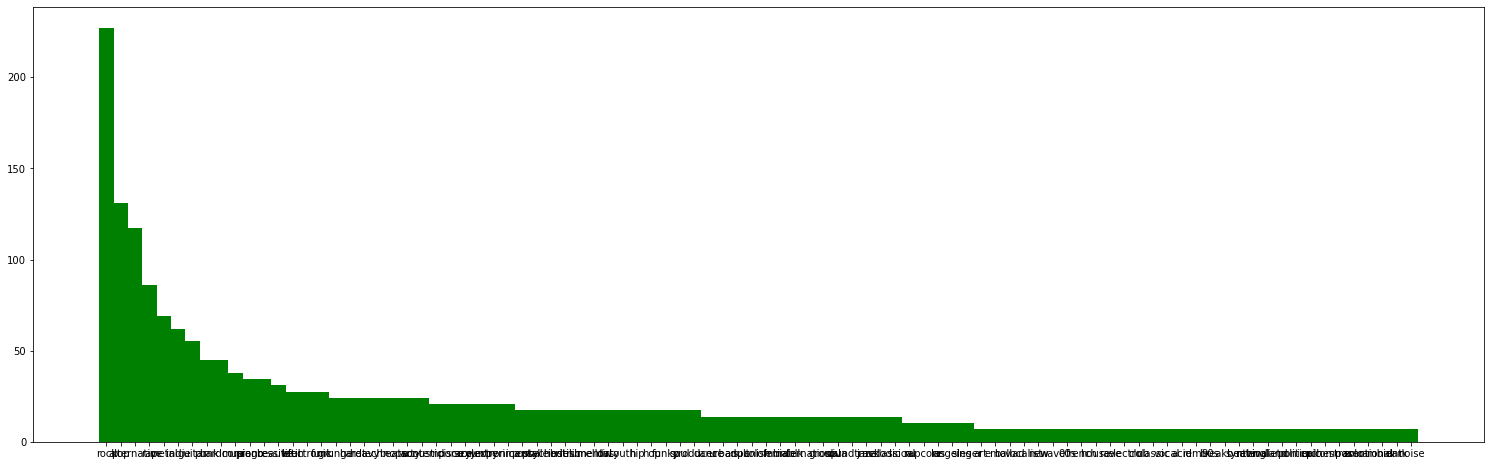

In [36]:
plt.figure(figsize = (26, 8), facecolor = None)
plt.bar(user_tfidf.keys(), user_tfidf.values(), 1, color='g')


# Evaluation
* song is a good recommendation if it is the same genre

we decide that a it is a good recommendation if half the genres overlap. Between the query and the recommendations

In [51]:

def evaluate(query, recommendations):
    K = 10 # number of retrieved items to query song
    aps = []
    for i, song in enumerate(recommended_songs):
        p = np.zeros(K)  # precisions at k
        r = np.zeros(K)  # recalls at k
        df.song[]
        y_true = query # genres of the query
        y_pred = 1 # genres of the recommendation

        # k ranking
        for k in range(1, K+1):
            tp = np.sum((y_true == y_pred[:k]))

            p[k-1] = tp/len(y_pred[:k])
            # fraction of objects predicted to be positive among all positive objects
            r[k-1] = tp/K
            # True Positive Identification Rate (TPIR): 
            # Probability of observing the correct identity within the top K ranks

        # binarize predictions
        y_pred[y_pred != y_true] = 0
        y_pred[y_pred == y_true] = 1

        ap = 1/(y_pred.sum() + 1e-9) * (p @ y_pred)
        aps.append(ap)

    maP = np.mean(aps)
    return maP

SyntaxError: invalid syntax (3998973970.py, line 7)

In [52]:
songs_to_
for user in users:
    recommendation = get_recommendation(song)

NameError: name 'songs_to_' is not defined